# TFM: INTRODUCCIÓN DE LA IA Y ML EN UNA EMPRESA DE HOSTELERÍA REAL


## Predicción de la cancelación de las reservas

Realizado por:

*   Ilix Manuel Díaz Castro
*   Alejandro Juan Moreno Calderón
*   Diego Sierra Corredera
*   Ernesto Villalobos García

# ETL

## Carga de librerías

In [1]:
#Importamos las librerías
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import random

import joblib

import warnings
warnings.filterwarnings('ignore' )

#pd.set_option('mode.chained_assignment', None)

## Extracción de datos

Hemos recibido la información en bruto de 5 archivos diferentes:


1.   Reservas 2016 al 2020.csv
2.   reservas 2021 al 2022.csv
3.   Precios del 2016 al 2023.csv
4.   Cardex 2016 al 2020.csv
5.   cardex 2021 al 2022.csv

Hemos unificado 1. y 2. en:

6. reservas.csv

Igualmente hemos unificado 3. y 6. en el csv con el que trabajaremos el modelo:

7. reservas_total.csv

Por último hemos unificado 4. y 5. en:

8. cardex_total.csv






In [2]:
#Definimos las columnas que usaremos del csv de reservas de 2016 a 2020
columnas_reservas_16_20 = ['Estado reserva', 'Año', 'Reserva', 'Desglose', 'Fecha entrada', 'Noches', 'Tip.Hab.Uso',
                           'Tip.Hab.Fra.', 'Régimen uso', 'Régimen factura', 'AD', 'JR', 'NI', 'CU', 'Agencia',
                           'Fecha Borrado', 'Fecha venta', 'Hora venta', 'Tipo facturación estancia', 'Trato']

#Leemos el csv de reservas de 2016 a 2020 y renombramos la columna Fecha Borrado
reservas_16_20 = pd.read_csv('Datasets originales/Reservas 2016 al 2020.csv', sep=';', encoding='ISO-8859-1', usecols=columnas_reservas_16_20)
reservas_16_20.rename(columns={'Fecha Borrado': 'Fecha Anulacion'},inplace=True)
reservas_16_20

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,AD,JR,NI,CU,Agencia,Fecha Anulacion,Fecha venta,Hora venta,Tipo facturación estancia,Trato
0,Anulada,2015,9716.0,1,26/06/2016,5,EC,EC,PC,PC,320,0,0,0,DIRECTOS,23/05/2016,26/08/2015,12:43:02,Directo,Cliente
1,Salida,2015,10449.0,1,14/08/2016,6,DSC,DSC,MPC+,MPC+,2,0,0,0,HP,NaN,23/09/2015,16:27:14,Agencia,Cliente
2,Salida,2015,10449.0,2,14/08/2016,6,DSC,DSC,MPC+,MPC+,2,1,0,0,HP,NaN,23/09/2015,16:27:14,Agencia,Cliente
3,Salida,2015,10502.0,1,08/09/2016,3,EC,EC,PC+,PC+,2,0,0,0,MONTIJO,NaN,21/10/2015,11:58:25,Agencia,Cliente
4,Salida,2015,10502.0,2,08/09/2016,3,EC,EC,PC,PC+,2,0,0,0,MONTIJO,NaN,21/10/2015,11:58:25,Agencia,Cliente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39794,Salida,2020,6043.0,1,11/09/2020,2,DSC,EC,MPC+,MPC+,2,0,0,0,DIRECTOS,NaN,11/09/2020,17:01:41,Directo,Cliente
39795,Salida,2020,6044.0,1,11/09/2020,2,DSM,EM,PC+,PC+,2,0,1,0,DIRECTOS,NaN,11/09/2020,18:29:21,Directo,Cliente
39796,Salida,2020,6045.0,1,11/09/2020,2,DSM,EC,PC+,PC+,2,0,0,0,HP,NaN,11/09/2020,21:17:18,Agencia,Cliente
39797,Anulada,2020,6047.0,1,12/09/2020,2,DSM,EC,SA,SA,2,0,0,0,DUNAS,12/09/2020,12/09/2020,12:10:25,Agencia,Cliente


In [3]:
#Definimos las columnas que usaremos del csv de reservas de 2019 y 2021
columnas_reservas_21 = ['Estado reserva', 'Año', 'Reserva', 'Desglose', 'Fecha entrada', 'Noches', 'Tip.Hab.Uso',
                        'Tip.Hab.Fra.', 'Régimen uso', 'Régimen factura', 'AD', 'JR', 'NI', 'CU', 'Agencia',
                        'Fecha Borrado', 'Fecha venta', 'Hora venta', 'Tipo facturación estancia', 'Trato']

#Leemos el csv de reservas de 2019 y 2021. Realmente solo nos interesan aquellas de 2021, así que tendremos que filtrar estos valores
reservas_19_21 = pd.read_csv('Datasets originales/Reservas 2019 y 2021.csv', sep=';', usecols=columnas_reservas_21)
#Renombramos la columna Fecha Borrado
reservas_19_21.rename(columns={'Fecha Borrado': 'Fecha Anulacion'},inplace=True)
reservas_19_21

,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,AD,JR,NI,CU,Estado reserva,Agencia,Fecha Anulacion,Fecha venta,Hora venta,Tipo facturación estancia,Trato
0,2018,3759,1,21/06/2019,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,25/06/2018,10:52:06,Directo,Cliente
1,2018,3759,2,21/06/2019,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,25/06/2018,10:52:06,Directo,Cliente
2,2018,3759,3,21/06/2019,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,25/06/2018,10:52:06,Directo,Cliente
3,2018,3759,4,21/06/2019,3,DSM,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,25/06/2018,10:52:06,Directo,Cliente
4,2018,3759,5,21/06/2019,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,25/06/2018,10:52:06,Directo,Cliente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,2021,6196,1,13/09/2021,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,HP,NaN,12/09/2021,9:05:50,Agencia,Cliente
11745,2021,6198,1,13/09/2021,1,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,13/09/2021,11:27:20,Directo,Cliente
11746,2021,6199,1,13/09/2021,4,DSC,EC,SA,SA,2,0,0,0,Salida,DIRECTOS,NaN,13/09/2021,12:13:58,Directo,Cliente
11747,2021,6200,1,15/09/2021,2,DVC,EC,PC+,PC+,2,0,0,0,Salida,GALAN,NaN,13/09/2021,12:42:36,Agencia,Cliente


In [4]:
#Filtramos las reservas del año 2021
reservas_21=reservas_19_21.loc[reservas_19_21['Año']>2019]
reservas_21

,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,AD,JR,NI,CU,Estado reserva,Agencia,Fecha Anulacion,Fecha venta,Hora venta,Tipo facturación estancia,Trato
6187,2020,6053,1,04/07/2021,5,DVC,DVC,MPA+,MPA+,2,0,1,0,Salida,DIRECTOS,NaN,23/11/2020,10:25:57,Directo,Cliente
6188,2020,6056,1,21/07/2021,3,DSC,EC,PC+,PC+,2,2,0,0,Salida,HP,NaN,01/12/2020,12:18:26,Agencia,Cliente
6189,2020,6057,1,05/07/2021,4,DSM,EM,PC+,PC+,2,0,0,1,Salida,HP,NaN,01/12/2020,12:20:12,Agencia,Cliente
6190,2020,6058,1,08/07/2021,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,HP,NaN,01/12/2020,12:22:23,Agencia,Cliente
6191,2020,6059,1,19/07/2021,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,HP,NaN,01/12/2020,12:24:31,Agencia,Cliente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,2021,6196,1,13/09/2021,3,DSC,EC,PC+,PC+,2,0,0,0,Salida,HP,NaN,12/09/2021,9:05:50,Agencia,Cliente
11745,2021,6198,1,13/09/2021,1,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,13/09/2021,11:27:20,Directo,Cliente
11746,2021,6199,1,13/09/2021,4,DSC,EC,SA,SA,2,0,0,0,Salida,DIRECTOS,NaN,13/09/2021,12:13:58,Directo,Cliente
11747,2021,6200,1,15/09/2021,2,DVC,EC,PC+,PC+,2,0,0,0,Salida,GALAN,NaN,13/09/2021,12:42:36,Agencia,Cliente


In [5]:
#Definimos las columnas que usaremos del csv de reservas de 2022
columnas_reservas_22 = ['Estado reserva', 'Año', 'Reserva', 'Desglose', 'Fecha entrada', 'Noches', 'Tip.Hab.Uso',
                        'Tip.Hab.Fra.', 'Régimen uso', 'Régimen factura', 'AD', 'JR', 'NI', 'CU', 'Agencia',
                        'Fecha Anulacion', 'Fecha venta', 'Hora venta', 'Tipo facturación estancia', 'Trato']

#Leemos el csv de reservas de 2022
reservas_22 = pd.read_csv('Datasets originales/Reservas 2021 al 2022.csv', sep=';', usecols=columnas_reservas_22)
reservas_22

,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,AD,JR,NI,CU,Estado reserva,Agencia,Fecha Anulacion,Fecha venta,Hora venta,Tipo facturación estancia,Trato
0,2022,437,1,30/03/2022,2,RDT,EC,HD,HD,1,0,0,0,Salida,DIRECTOS,NaN,29/03/2022,15:10:41,Directo,Cliente
1,2022,421,1,29/03/2022,2,SUITE,EC,HD,HD,1,0,0,0,Salida,DIRECTOS,NaN,28/03/2022,9:16:48,Directo,Cliente
2,2022,382,29,25/03/2022,2,DSC,EC,PC+,PC+,1,0,0,0,Salida,CELTA,NaN,22/03/2022,9:58:36,Agencia,Cliente
3,2022,382,28,25/03/2022,2,DSC,EC,PC+,PC+,1,0,0,0,Salida,CELTA,NaN,22/03/2022,9:58:36,Agencia,Cliente
4,2022,382,27,25/03/2022,2,DSM,EC,PC+,PC+,1,0,0,0,Salida,CELTA,NaN,22/03/2022,9:58:36,Agencia,Cliente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13227,2021,6211,3,16/09/2022,2,DSC,EC,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,03/11/2021,12:14:35,Directo,Cliente
13228,2021,6211,2,16/09/2022,2,DVM,DSM,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,03/11/2021,12:14:35,Directo,Cliente
13229,2021,6211,1,16/09/2022,2,DVM,DVM,PC+,PC+,2,0,0,0,Salida,DIRECTOS,NaN,03/11/2021,12:14:35,Directo,Cliente
13230,2021,6207,2,17/08/2022,7,DSC,DSC,MPC+,MPC+,2,0,0,0,Anulada,HP,28/06/2022,26/10/2021,10:53:17,Agencia,Cliente


In [6]:
#Concatenamos los dataframes de reservas
reservas = pd.concat([reservas_16_20, reservas_21, reservas_22], ignore_index=True)
reservas

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,AD,JR,NI,CU,Agencia,Fecha Anulacion,Fecha venta,Hora venta,Tipo facturación estancia,Trato
0,Anulada,2015,9716.0,1,26/06/2016,5,EC,EC,PC,PC,320,0,0,0,DIRECTOS,23/05/2016,26/08/2015,12:43:02,Directo,Cliente
1,Salida,2015,10449.0,1,14/08/2016,6,DSC,DSC,MPC+,MPC+,2,0,0,0,HP,NaN,23/09/2015,16:27:14,Agencia,Cliente
2,Salida,2015,10449.0,2,14/08/2016,6,DSC,DSC,MPC+,MPC+,2,1,0,0,HP,NaN,23/09/2015,16:27:14,Agencia,Cliente
3,Salida,2015,10502.0,1,08/09/2016,3,EC,EC,PC+,PC+,2,0,0,0,MONTIJO,NaN,21/10/2015,11:58:25,Agencia,Cliente
4,Salida,2015,10502.0,2,08/09/2016,3,EC,EC,PC,PC+,2,0,0,0,MONTIJO,NaN,21/10/2015,11:58:25,Agencia,Cliente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58588,Salida,2021,6211.0,3,16/09/2022,2,DSC,EC,PC+,PC+,2,0,0,0,DIRECTOS,NaN,03/11/2021,12:14:35,Directo,Cliente
58589,Salida,2021,6211.0,2,16/09/2022,2,DVM,DSM,PC+,PC+,2,0,0,0,DIRECTOS,NaN,03/11/2021,12:14:35,Directo,Cliente
58590,Salida,2021,6211.0,1,16/09/2022,2,DVM,DVM,PC+,PC+,2,0,0,0,DIRECTOS,NaN,03/11/2021,12:14:35,Directo,Cliente
58591,Anulada,2021,6207.0,2,17/08/2022,7,DSC,DSC,MPC+,MPC+,2,0,0,0,HP,28/06/2022,26/10/2021,10:53:17,Agencia,Cliente


In [7]:
#Definimos las columnas que usaremos del csv de los precios de reservas
columnas_precios_reservas = ['Año', 'Reserva', 'Desglose', 'Tipo precio', 'Precio total', 'Precio alojamiento',
                             'Precio desayuno', 'Precio almuerzo', 'Precio cena', 'Secuencia']

#Leemos el csv completo de los precios de reservas
precios_reservas = pd.read_csv('Datasets originales/Precios del 2016 al 2023.csv', sep=';', usecols=columnas_precios_reservas)
precios_reservas

,Año,Reserva,Desglose,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Secuencia
0,2022,258,1,Persona,40,"30,4","1,6",4,4,0
1,2022,274,1,Habitacion,"137,5","104,5","5,5","13,75","13,75",0
2,2022,287,1,Habitacion,110,"81,1","4,4",11,11,0
3,2022,146,1,Persona,40,"27,9","1,6",4,4,0
4,2022,272,1,Persona,39,"27,14","1,56","3,9","3,9",0
...,...,...,...,...,...,...,...,...,...,...
107814,2019,7928,1,Habitacion,"70,84","70,84",0,0,0,0
107815,2019,7929,1,Habitacion,"39,32","39,32",0,0,0,0
107816,2019,7930,1,Habitacion,"58,8","42,19","2,35","5,88","5,88",0
107817,2019,7931,1,Habitacion,"89,22","85,65","3,57",0,0,0


In [8]:
#Eliminamos los valores de secuencia mayor que 0. Después multiplicaremos los precios por el número de noches y eliminamos la columna
precios_reservas = precios_reservas[precios_reservas['Secuencia'] == 0]
precios_reservas.drop('Secuencia', axis=1, inplace=True)
precios_reservas

,Año,Reserva,Desglose,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena
0,2022,258,1,Persona,40,"30,4","1,6",4,4
1,2022,274,1,Habitacion,"137,5","104,5","5,5","13,75","13,75"
2,2022,287,1,Habitacion,110,"81,1","4,4",11,11
3,2022,146,1,Persona,40,"27,9","1,6",4,4
4,2022,272,1,Persona,39,"27,14","1,56","3,9","3,9"
...,...,...,...,...,...,...,...,...,...
107814,2019,7928,1,Habitacion,"70,84","70,84",0,0,0
107815,2019,7929,1,Habitacion,"39,32","39,32",0,0,0
107816,2019,7930,1,Habitacion,"58,8","42,19","2,35","5,88","5,88"
107817,2019,7931,1,Habitacion,"89,22","85,65","3,57",0,0


In [9]:
# Unimos ambos dataframes utilizando un "inner join" por las columnas en común (Año, reserva y desglose)
reservas_total = pd.merge(reservas, precios_reservas, on=["Año", "Reserva", "Desglose"], how="inner")
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Hora venta,Tipo facturación estancia,Trato,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena
0,Anulada,2015,9716.0,1,26/06/2016,5,EC,EC,PC,PC,...,26/08/2015,12:43:02,Directo,Cliente,Persona,30,"22,8","1,2",3,3
1,Salida,2015,10449.0,1,14/08/2016,6,DSC,DSC,MPC+,MPC+,...,23/09/2015,16:27:14,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87"
2,Salida,2015,10449.0,2,14/08/2016,6,DSC,DSC,MPC+,MPC+,...,23/09/2015,16:27:14,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87"
3,Salida,2015,10502.0,1,08/09/2016,3,EC,EC,PC+,PC+,...,21/10/2015,11:58:25,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77"
4,Salida,2015,10502.0,2,08/09/2016,3,EC,EC,PC,PC+,...,21/10/2015,11:58:25,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60881,Salida,2021,6211.0,3,16/09/2022,2,DSC,EC,PC+,PC+,...,03/11/2021,12:14:35,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32"
60882,Salida,2021,6211.0,2,16/09/2022,2,DVM,DSM,PC+,PC+,...,03/11/2021,12:14:35,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32"
60883,Salida,2021,6211.0,1,16/09/2022,2,DVM,DVM,PC+,PC+,...,03/11/2021,12:14:35,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32"
60884,Anulada,2021,6207.0,2,17/08/2022,7,DSC,DSC,MPC+,MPC+,...,26/10/2021,10:53:17,Agencia,Cliente,Habitacion,"214,74857","182,18857","8,59",0,"21,47"


In [10]:
# Guardamos el dataframe en un nuevo archivo CSV
reservas_total.to_csv("Outputs/reservas_total.csv", index=False)

In [11]:
#Definimos las columnas que usaremos del csv de cardex de 2016 a 2020
columnas_cardex_16_20 = ['Año', 'Reserva', 'Desglose', 'Fecha entrada', 'Sexo', 'Provincia residencia',
                         'Comunidad autónoma residencia', 'País residencia', 'Nacionalidad', 'Fecha nacimiento']

#Leemos el csv de cardex de 2016 a 2020
cardex_16_20 = pd.read_csv('Datasets originales/Cardex 2016 al 2020.csv', sep=';', usecols=columnas_cardex_16_20)
cardex_16_20

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Fecha nacimiento
0,2015,10449,1,14/08/2016,Femenino,20.0,PVA,ES,ES,07/04/1971
1,2015,10449,1,14/08/2016,Masculino,NaN,NaN,ES,ES,19/01/1970
2,2015,10449,2,14/08/2016,Masculino,NaN,NaN,ES,ES,19/01/1970
3,2015,10449,2,14/08/2016,Femenino,20.0,PVA,ES,ES,07/04/1971
4,2015,10449,2,14/08/2016,Masculino,NaN,NaN,ES,ES,01/01/2016
...,...,...,...,...,...,...,...,...,...,...
73336,2020,6044,1,11/09/2020,Masculino,NaN,NaN,ES,ES,01/01/2020
73337,2020,6045,1,11/09/2020,Femenino,10.0,EXT,ES,ES,07/04/1971
73338,2020,6045,1,11/09/2020,Masculino,10.0,EXT,ES,ES,22/08/1973
73339,2020,6048,1,12/09/2020,Femenino,6.0,EXT,ES,ES,12/05/1962


In [12]:
#Definimos las columnas que usaremos del csv de cardex de 2021 a 2022
columnas_cardex_21_22 = ['Año', 'Reserva', 'Desglose', 'Fecha entrada', 'Sexo', 'Provincia residencia',
                         'Comunidad autónoma residencia', 'País residencia', 'Nacionalidad', 'Año de nacimiento']

#Leemos el csv de cardex de 2021 a 2022
cardex_21_22 = pd.read_csv('Datasets originales/Cardex 2021 al 2022.csv', sep=';', usecols=columnas_cardex_21_22)
cardex_21_22

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento
0,2021,208,1,01/06/2021,Femenino,41.0,AND,ES,ES,1970.0
1,2021,208,1,01/06/2021,Masculino,NaN,NaN,ES,ES,1971.0
2,2021,337,1,01/06/2021,Femenino,41.0,AND,ES,ES,1984.0
3,2021,337,1,01/06/2021,Masculino,41.0,AND,ES,ES,1986.0
4,2021,325,1,02/06/2021,Femenino,NaN,NaN,ES,ES,1992.0
...,...,...,...,...,...,...,...,...,...,...
37419,2022,6866,1,24/09/2022,Masculino,NaN,NaN,ES,ES,1993.0
37420,2022,6867,1,24/09/2022,Masculino,14.0,AND,ES,ES,1960.0
37421,2022,6867,1,24/09/2022,Femenino,NaN,NaN,ES,ES,1970.0
37422,2022,6858,1,24/09/2022,Masculino,29.0,AND,ES,ES,1983.0


In [13]:
#Cambiamos la fecha de nacimiento por el año de nacimiento en el dataframe de 2016 a 2020
fecha = []
for i in range(len(cardex_16_20)):
    if isinstance(cardex_16_20['Fecha nacimiento'][i], float):
        fecha.append(None)
    else:
        fecha.append(datetime.strptime(cardex_16_20['Fecha nacimiento'][i], "%d/%m/%Y").year)
cardex_16_20['Año de nacimiento'] = fecha
cardex_16_20 = cardex_16_20.drop('Fecha nacimiento', axis=1)
cardex_16_20

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento
0,2015,10449,1,14/08/2016,Femenino,20.0,PVA,ES,ES,1971.0
1,2015,10449,1,14/08/2016,Masculino,NaN,NaN,ES,ES,1970.0
2,2015,10449,2,14/08/2016,Masculino,NaN,NaN,ES,ES,1970.0
3,2015,10449,2,14/08/2016,Femenino,20.0,PVA,ES,ES,1971.0
4,2015,10449,2,14/08/2016,Masculino,NaN,NaN,ES,ES,2016.0
...,...,...,...,...,...,...,...,...,...,...
73336,2020,6044,1,11/09/2020,Masculino,NaN,NaN,ES,ES,2020.0
73337,2020,6045,1,11/09/2020,Femenino,10.0,EXT,ES,ES,1971.0
73338,2020,6045,1,11/09/2020,Masculino,10.0,EXT,ES,ES,1973.0
73339,2020,6048,1,12/09/2020,Femenino,6.0,EXT,ES,ES,1962.0


In [14]:
#Concatenamos los dataframe de cardex
cardex_total = pd.concat([cardex_16_20, cardex_21_22], ignore_index=True)
cardex_total

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento
0,2015,10449,1,14/08/2016,Femenino,20.0,PVA,ES,ES,1971.0
1,2015,10449,1,14/08/2016,Masculino,NaN,NaN,ES,ES,1970.0
2,2015,10449,2,14/08/2016,Masculino,NaN,NaN,ES,ES,1970.0
3,2015,10449,2,14/08/2016,Femenino,20.0,PVA,ES,ES,1971.0
4,2015,10449,2,14/08/2016,Masculino,NaN,NaN,ES,ES,2016.0
...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,24/09/2022,Masculino,NaN,NaN,ES,ES,1993.0
110761,2022,6867,1,24/09/2022,Masculino,14.0,AND,ES,ES,1960.0
110762,2022,6867,1,24/09/2022,Femenino,NaN,NaN,ES,ES,1970.0
110763,2022,6858,1,24/09/2022,Masculino,29.0,AND,ES,ES,1983.0


In [15]:
# Guardamos el dataframe en un nuevo archivo CSV
cardex_total.to_csv("Outputs/cardex_total.csv", index=False)

## Preprocesamiento de reservas

In [16]:
#Leemos el csv para recuperar el dataframe de reservas
reservas_total = pd.read_csv('Outputs/reservas_total.csv')

# Convertimos las columnas correspondientes en formato de fecha
reservas_total['Fecha entrada'] = pd.to_datetime(reservas_total['Fecha entrada'], dayfirst=True)
reservas_total['Fecha venta'] = pd.to_datetime(reservas_total['Fecha venta'], dayfirst=True)
reservas_total['Hora venta'] = pd.to_datetime(reservas_total['Hora venta'], format='%H:%M:%S').dt.hour
reservas_total['Fecha Anulacion'] = pd.to_datetime(reservas_total['Fecha Anulacion'], dayfirst=True)
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Hora venta,Tipo facturación estancia,Trato,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena
0,Anulada,2015,9716.0,1,2016-06-26,5,EC,EC,PC,PC,...,2015-08-26,12,Directo,Cliente,Persona,30,"22,8","1,2",3,3
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,16,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87"
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,16,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87"
3,Salida,2015,10502.0,1,2016-09-08,3,EC,EC,PC+,PC+,...,2015-10-21,11,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77"
4,Salida,2015,10502.0,2,2016-09-08,3,EC,EC,PC,PC+,...,2015-10-21,11,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60881,Salida,2021,6211.0,3,2022-09-16,2,DSC,EC,PC+,PC+,...,2021-11-03,12,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32"
60882,Salida,2021,6211.0,2,2022-09-16,2,DVM,DSM,PC+,PC+,...,2021-11-03,12,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32"
60883,Salida,2021,6211.0,1,2022-09-16,2,DVM,DVM,PC+,PC+,...,2021-11-03,12,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32"
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2021-10-26,10,Agencia,Cliente,Habitacion,"214,74857","182,18857","8,59",0,"21,47"


In [17]:
#Función para asignar los intervalos de tiempo para la hora de venta
def condition(x):
    if (0 <= x < 6):
        return 'Madrugada'
    elif (x < 12):
        return 'Mañana'
    elif (x < 18):
        return 'Tarde'
    else:
        return 'Noche'

#Aplicamos esta función a la variable horario venta
reservas_total['Horario venta'] = reservas_total['Hora venta'].apply(condition)
reservas_total

#Eliminamos la columna
reservas_total.drop('Hora venta', axis=1, inplace=True)
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Tipo facturación estancia,Trato,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
0,Anulada,2015,9716.0,1,2016-06-26,5,EC,EC,PC,PC,...,2015-08-26,Directo,Cliente,Persona,30,"22,8","1,2",3,3,Tarde
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87",Tarde
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87",Tarde
3,Salida,2015,10502.0,1,2016-09-08,3,EC,EC,PC+,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
4,Salida,2015,10502.0,2,2016-09-08,3,EC,EC,PC,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60881,Salida,2021,6211.0,3,2022-09-16,2,DSC,EC,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60882,Salida,2021,6211.0,2,2022-09-16,2,DVM,DSM,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60883,Salida,2021,6211.0,1,2022-09-16,2,DVM,DVM,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2021-10-26,Agencia,Cliente,Habitacion,"214,74857","182,18857","8,59",0,"21,47",Mañana


In [18]:
#Filtramos las reservas de los meses de verano (junio, julio, agosto y septiembre)
reservas_total = reservas_total.loc[(reservas_total['Fecha entrada'].dt.month >= 6) & (reservas_total['Fecha entrada'].dt.month <= 9), ]
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Tipo facturación estancia,Trato,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
0,Anulada,2015,9716.0,1,2016-06-26,5,EC,EC,PC,PC,...,2015-08-26,Directo,Cliente,Persona,30,"22,8","1,2",3,3,Tarde
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87",Tarde
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87",Tarde
3,Salida,2015,10502.0,1,2016-09-08,3,EC,EC,PC+,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
4,Salida,2015,10502.0,2,2016-09-08,3,EC,EC,PC,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60881,Salida,2021,6211.0,3,2022-09-16,2,DSC,EC,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60882,Salida,2021,6211.0,2,2022-09-16,2,DVM,DSM,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60883,Salida,2021,6211.0,1,2022-09-16,2,DVM,DVM,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2021-10-26,Agencia,Cliente,Habitacion,"214,74857","182,18857","8,59",0,"21,47",Mañana


In [19]:
#Comprobamos los nulos
reservas_total.isnull().sum()

Estado reserva                   0
Año                              0
Reserva                          0
Desglose                         0
Fecha entrada                    0
Noches                           0
Tip.Hab.Uso                      0
Tip.Hab.Fra.                     0
Régimen uso                      0
Régimen factura                  0
AD                               0
JR                               0
NI                               0
CU                               0
Agencia                          0
Fecha Anulacion              46300
Fecha venta                      0
Tipo facturación estancia        0
Trato                            0
Tipo precio                      0
Precio total                     0
Precio alojamiento               0
Precio desayuno                  0
Precio almuerzo                  0
Precio cena                      0
Horario venta                    0
dtype: int64

In [20]:
#Observamos que las filas con tipo de precio por persona pertenecen a grupos, que no nos interesa analizar
reservas_total.loc[(reservas_total['Tipo precio'] == 'Persona'), ]

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Tipo facturación estancia,Trato,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
0,Anulada,2015,9716.0,1,2016-06-26,5,EC,EC,PC,PC,...,2015-08-26,Directo,Cliente,Persona,30,"22,8","1,2",3,3,Tarde
3,Salida,2015,10502.0,1,2016-09-08,3,EC,EC,PC+,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
4,Salida,2015,10502.0,2,2016-09-08,3,EC,EC,PC,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
5,Salida,2015,10502.0,3,2016-09-08,3,EC,EC,PC,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
6,Salida,2015,10502.0,4,2016-09-08,3,EC,EC,PC,PC+,...,2015-10-21,Agencia,Cliente,Persona,"47,66551","36,21551","1,91","4,77","4,77",Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60879,Salida,2021,6211.0,5,2022-09-16,2,DSC,EC,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60880,Salida,2021,6211.0,4,2022-09-16,2,DSC,EC,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60881,Salida,2021,6211.0,3,2022-09-16,2,DSC,EC,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde
60882,Salida,2021,6211.0,2,2022-09-16,2,DVM,DSM,PC+,PC+,...,2021-11-03,Directo,Cliente,Persona,"43,15882","30,28882","1,73","4,32","4,32",Tarde


In [21]:
#Filtramos las reservas por tipo de precio por Habitación
reservas_total = reservas_total.loc[(reservas_total['Tipo precio'] == 'Habitacion'), ]
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Tipo facturación estancia,Trato,Tipo precio,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87",Tarde
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,Habitacion,"148,72","127,9","5,95",0,"14,87",Tarde
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,2015-11-04,Directo,Cliente,Habitacion,"104,04","104,04",0,0,0,Mañana
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,2015-11-06,Directo,Cliente,Habitacion,"99,9","75,92",4,"9,99","9,99",Tarde
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,2015-11-30,Directo,Cliente,Habitacion,"114,045","86,685","4,56","11,4","11,4",Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,2021-11-17,Agencia,Cliente,Habitacion,"154,34333","114,81333","6,17","15,43","15,43",Mañana
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,2021-11-16,Agencia,Cliente,Habitacion,"250,585","187,945","10,02","25,06","25,06",Mañana
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,2021-11-16,Agencia,Cliente,Habitacion,"144,65","107,42","5,79","14,47","14,47",Mañana
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2021-10-26,Agencia,Cliente,Habitacion,"214,74857","182,18857","8,59",0,"21,47",Mañana


In [22]:
#Comprobamos que solo queda el valor Habitación
reservas_total['Tipo precio'].value_counts()

Habitacion    54832
Name: Tipo precio, dtype: int64

In [23]:
#Eliminamos la columna
reservas_total.drop('Tipo precio', axis=1, inplace=True)
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha Anulacion,Fecha venta,Tipo facturación estancia,Trato,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,NaT,2015-09-23,Agencia,Cliente,"148,72","127,9","5,95",0,"14,87",Tarde
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,NaT,2015-09-23,Agencia,Cliente,"148,72","127,9","5,95",0,"14,87",Tarde
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,2016-02-10,2015-11-04,Directo,Cliente,"104,04","104,04",0,0,0,Mañana
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,NaT,2015-11-06,Directo,Cliente,"99,9","75,92",4,"9,99","9,99",Tarde
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,NaT,2015-11-30,Directo,Cliente,"114,045","86,685","4,56","11,4","11,4",Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,2022-05-29,2021-11-17,Agencia,Cliente,"154,34333","114,81333","6,17","15,43","15,43",Mañana
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,2022-03-01,2021-11-16,Agencia,Cliente,"250,585","187,945","10,02","25,06","25,06",Mañana
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,2022-03-01,2021-11-16,Agencia,Cliente,"144,65","107,42","5,79","14,47","14,47",Mañana
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2022-06-28,2021-10-26,Agencia,Cliente,"214,74857","182,18857","8,59",0,"21,47",Mañana


In [24]:
reservas_total.dtypes

Estado reserva                       object
Año                                   int64
Reserva                             float64
Desglose                              int64
Fecha entrada                datetime64[ns]
Noches                                int64
Tip.Hab.Uso                          object
Tip.Hab.Fra.                         object
Régimen uso                          object
Régimen factura                      object
AD                                    int64
JR                                    int64
NI                                    int64
CU                                    int64
Agencia                              object
Fecha Anulacion              datetime64[ns]
Fecha venta                  datetime64[ns]
Tipo facturación estancia            object
Trato                                object
Precio total                         object
Precio alojamiento                   object
Precio desayuno                      object
Precio almuerzo                 

In [25]:
#Convertimos los precios a floats, sustituyendo previamente las comas por puntos, y multiplicamos por el numero de noches
reservas_total['Precio total'] = reservas_total['Precio total'].str.replace(',', '.')
reservas_total['Precio total'] = reservas_total['Precio total'].astype(float)
reservas_total['Precio total'] = reservas_total['Precio total'] * reservas_total['Noches']

reservas_total['Precio alojamiento'] = reservas_total['Precio alojamiento'].str.replace(',', '.')
reservas_total['Precio alojamiento'] = reservas_total['Precio alojamiento'].astype(float)
reservas_total['Precio alojamiento'] = reservas_total['Precio alojamiento'] * reservas_total['Noches']

reservas_total['Precio desayuno'] = reservas_total['Precio desayuno'].str.replace(',', '.')
reservas_total['Precio desayuno'] = reservas_total['Precio desayuno'].astype(float)
reservas_total['Precio desayuno'] = reservas_total['Precio desayuno'] * reservas_total['Noches']

reservas_total['Precio almuerzo'] = reservas_total['Precio almuerzo'].str.replace(',', '.')
reservas_total['Precio almuerzo'] = reservas_total['Precio almuerzo'].astype(float)
reservas_total['Precio almuerzo'] = reservas_total['Precio almuerzo'] * reservas_total['Noches']

reservas_total['Precio cena'] = reservas_total['Precio cena'].str.replace(',', '.')
reservas_total['Precio cena'] = reservas_total['Precio cena'].astype(float)
reservas_total['Precio cena'] = reservas_total['Precio cena'] * reservas_total['Noches']

reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha Anulacion,Fecha venta,Tipo facturación estancia,Trato,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,NaT,2015-09-23,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,NaT,2015-09-23,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,2016-02-10,2015-11-04,Directo,Cliente,416.16000,416.16000,0.00,0.00,0.00,Mañana
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,NaT,2015-11-06,Directo,Cliente,599.40000,455.52000,24.00,59.94,59.94,Tarde
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,NaT,2015-11-30,Directo,Cliente,228.09000,173.37000,9.12,22.80,22.80,Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,2022-05-29,2021-11-17,Agencia,Cliente,463.02999,344.43999,18.51,46.29,46.29,Mañana
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,2022-03-01,2021-11-16,Agencia,Cliente,751.75500,563.83500,30.06,75.18,75.18,Mañana
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,2022-03-01,2021-11-16,Agencia,Cliente,433.95000,322.26000,17.37,43.41,43.41,Mañana
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2022-06-28,2021-10-26,Agencia,Cliente,1503.23999,1275.31999,60.13,0.00,150.29,Mañana


In [26]:
#Los Junior computarán como adultos para las reservas aunque en el cardex sean considerados menores de edad
reservas_total['AD'] = reservas_total['JR'] + reservas_total['AD']

#Eliminamos la columna
reservas_total.drop('JR', axis=1, inplace=True)
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha Anulacion,Fecha venta,Tipo facturación estancia,Trato,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,NaT,2015-09-23,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,NaT,2015-09-23,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,2016-02-10,2015-11-04,Directo,Cliente,416.16000,416.16000,0.00,0.00,0.00,Mañana
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,NaT,2015-11-06,Directo,Cliente,599.40000,455.52000,24.00,59.94,59.94,Tarde
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,NaT,2015-11-30,Directo,Cliente,228.09000,173.37000,9.12,22.80,22.80,Mañana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,2022-05-29,2021-11-17,Agencia,Cliente,463.02999,344.43999,18.51,46.29,46.29,Mañana
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,2022-03-01,2021-11-16,Agencia,Cliente,751.75500,563.83500,30.06,75.18,75.18,Mañana
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,2022-03-01,2021-11-16,Agencia,Cliente,433.95000,322.26000,17.37,43.41,43.41,Mañana
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2022-06-28,2021-10-26,Agencia,Cliente,1503.23999,1275.31999,60.13,0.00,150.29,Mañana


In [27]:
#Calculamos el número de huéspedes en cada habitación
reservas_total['Huespedes'] = reservas_total['AD'] + reservas_total['NI'] + reservas_total['CU']
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Fecha venta,Tipo facturación estancia,Trato,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde,2
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,2015-09-23,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde,3
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,2015-11-04,Directo,Cliente,416.16000,416.16000,0.00,0.00,0.00,Mañana,2
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,2015-11-06,Directo,Cliente,599.40000,455.52000,24.00,59.94,59.94,Tarde,3
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,2015-11-30,Directo,Cliente,228.09000,173.37000,9.12,22.80,22.80,Mañana,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,2021-11-17,Agencia,Cliente,463.02999,344.43999,18.51,46.29,46.29,Mañana,2
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,2021-11-16,Agencia,Cliente,751.75500,563.83500,30.06,75.18,75.18,Mañana,3
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,2021-11-16,Agencia,Cliente,433.95000,322.26000,17.37,43.41,43.41,Mañana,3
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,2021-10-26,Agencia,Cliente,1503.23999,1275.31999,60.13,0.00,150.29,Mañana,2


In [28]:
#Analizamos la variable huéspedes
reservas_total['Huespedes'].describe()

count    54832.000000
mean         2.469379
std          0.742573
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: Huespedes, dtype: float64

In [29]:
#Agrupamos por reserva y año, y contamos la cantidad de habitaciones por reserva
reservas_total['Cantidad Habitaciones'] = reservas_total.groupby(['Reserva', 'Año'])['Desglose'].transform('max')

reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Tipo facturación estancia,Trato,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde,2,2
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde,3,2
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,Directo,Cliente,416.16000,416.16000,0.00,0.00,0.00,Mañana,2,1
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,Directo,Cliente,599.40000,455.52000,24.00,59.94,59.94,Tarde,3,4
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,Directo,Cliente,228.09000,173.37000,9.12,22.80,22.80,Mañana,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,Agencia,Cliente,463.02999,344.43999,18.51,46.29,46.29,Mañana,2,1
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,Agencia,Cliente,751.75500,563.83500,30.06,75.18,75.18,Mañana,3,1
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,Agencia,Cliente,433.95000,322.26000,17.37,43.41,43.41,Mañana,3,1
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,Agencia,Cliente,1503.23999,1275.31999,60.13,0.00,150.29,Mañana,2,2


In [30]:
#Analizamos la variable duración días
reservas_total['Cantidad Habitaciones'].describe()

count    54832.000000
mean         2.626660
std          6.503675
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         75.000000
Name: Cantidad Habitaciones, dtype: float64

In [31]:
#Nos quedamos con todas las reservas con 5 o menos habitaciones reservadas
reservas_total = reservas_total.loc[(reservas_total['Cantidad Habitaciones'] <= 5),]
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Tipo facturación estancia,Trato,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde,2,2
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,Agencia,Cliente,892.32000,767.40000,35.70,0.00,89.22,Tarde,3,2
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,Directo,Cliente,416.16000,416.16000,0.00,0.00,0.00,Mañana,2,1
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,Directo,Cliente,599.40000,455.52000,24.00,59.94,59.94,Tarde,3,4
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,Directo,Cliente,228.09000,173.37000,9.12,22.80,22.80,Mañana,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,Agencia,Cliente,463.02999,344.43999,18.51,46.29,46.29,Mañana,2,1
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,Agencia,Cliente,751.75500,563.83500,30.06,75.18,75.18,Mañana,3,1
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,Agencia,Cliente,433.95000,322.26000,17.37,43.41,43.41,Mañana,3,1
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,Agencia,Cliente,1503.23999,1275.31999,60.13,0.00,150.29,Mañana,2,2


In [32]:
# Sacamos el mes de entrada, salida y venta de la reserva
reservas_total['Mes Entrada'] = pd.to_datetime(reservas_total['Fecha entrada'], format='%Y-%b-%d').dt.strftime('%B')
reservas_total['Mes Venta'] = pd.to_datetime(reservas_total['Fecha venta'], format='%Y-%b-%d').dt.strftime('%B')
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,892.32000,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,892.32000,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,599.40000,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,228.09000,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,463.02999,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,751.75500,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,433.95000,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,1503.23999,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October


In [33]:
#Calculamos la columna Antelación, como el número de días de antelación con que se hace la reserva
reservas_total['Antelacion'] = (reservas_total['Fecha entrada'] - reservas_total['Fecha venta']).dt.days
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
1,Salida,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September,326
2,Salida,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September,326
18,Anulada,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November,313
22,Salida,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November,233
35,Salida,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,Anulada,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November,271
60840,Anulada,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November,243
60841,Anulada,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November,227
60884,Anulada,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October,295


In [34]:
#Comprobamos que los calculos cuadran
reservas_total.loc[(reservas_total['Antelacion']<15),][['Fecha venta', 'Fecha entrada', 'Antelacion']]

,Fecha venta,Fecha entrada,Antelacion
2128,2016-06-03,2016-06-15,12
2130,2016-06-03,2016-06-16,13
2131,2016-06-03,2016-06-17,14
2141,2016-06-04,2016-06-18,14
2157,2016-06-06,2016-06-15,9
...,...,...,...
58482,2022-06-18,2022-07-01,13
58494,2022-06-18,2022-07-01,13
58495,2022-06-18,2022-07-01,13
58517,2022-06-17,2022-07-01,14


In [35]:
#Revisamos las filas con una antelación menor a 0
reservas_total.loc[(reservas_total['Antelacion'] < 0),][['Reserva', 'Año', 'Fecha entrada', 'Fecha venta', 'Fecha Anulacion', 'Antelacion', 'Noches', 'Estado reserva']]

,Reserva,Año,Fecha entrada,Fecha venta,Fecha Anulacion,Antelacion,Noches,Estado reserva
3859,4690.0,2016,2016-07-01,2016-07-02,NaT,-1,2,Salida
7472,7972.0,2016,2016-08-26,2016-08-27,NaT,-1,4,Salida
7910,8329.0,2016,2016-09-06,2016-09-07,NaT,-1,1,Salida
7945,8363.0,2016,2016-09-07,2016-09-08,NaT,-1,1,Salida
13707,5611.0,2017,2017-07-17,2017-07-18,2017-07-18,-1,1,Anulada
27689,3327.0,2019,2019-06-16,2019-06-17,NaT,-1,7,Salida
31799,6884.0,2019,2019-08-10,2019-08-11,NaT,-1,1,Salida
36658,2142.0,2020,2020-07-11,2020-07-12,NaT,-1,1,Salida
36659,2142.0,2020,2020-07-11,2020-07-12,NaT,-1,1,Salida
36660,2144.0,2020,2020-07-11,2020-07-12,NaT,-1,1,Salida


In [36]:
#Eliminamos estas filas
reservas_total = reservas_total.loc[reservas_total['Antelacion'] >= 0,]

In [37]:
# Convertimos 'Estado reserva' a una variable numérica
reservas_total['Estado reserva'] = reservas_total['Estado reserva'].apply(lambda x: 1 if x == 'Anulada' else 0)
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
1,0,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September,326
2,0,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September,326
18,1,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November,313
22,0,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November,233
35,0,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,1,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November,271
60840,1,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November,243
60841,1,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November,227
60884,1,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October,295


In [38]:
#Realizamos el conteo de tipos de habitaciones
reservas_total['Tip.Hab.Fra.'].value_counts()

EC       24197
DSC      14219
EM        6142
DSM       4885
DVM       1971
DVC        271
IND        139
A           73
SUITE       19
DPC          7
DS           3
RDT          1
DPM          1
Name: Tip.Hab.Fra., dtype: int64

In [39]:
#Eliminamos las reservas en habitaciones DPC, DPM, DS y RDT
reservas_total = reservas_total.loc[(reservas_total['Tip.Hab.Fra.'] != 'DPC'),]
reservas_total = reservas_total.loc[(reservas_total['Tip.Hab.Fra.'] != 'DS'),]
reservas_total = reservas_total.loc[(reservas_total['Tip.Hab.Fra.'] != 'RDT'),]
reservas_total = reservas_total.loc[(reservas_total['Tip.Hab.Fra.'] != 'DPM'),]
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
1,0,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September,326
2,0,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC+,MPC+,...,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September,326
18,1,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November,313
22,0,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November,233
35,0,2015,10539.0,1,2016-07-08,2,EC,EC,PC+,PC+,...,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60839,1,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC+,PC+,...,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November,271
60840,1,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC+,PC+,...,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November,243
60841,1,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC+,PC+,...,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November,227
60884,1,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC+,MPC+,...,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October,295


In [40]:
#Realizamos el conteo de regimenes facturados
reservas_total['Régimen factura'].value_counts()

PC+     21038
HD       8629
MPA+     8496
SA       8392
MPC+     5244
PC         59
MPC        37
MPA        21
Name: Régimen factura, dtype: int64

In [41]:
#Juntamos los regimenes con + y sin +
dic = {'PC+': 'PC', 'MPC+': 'MPC', 'MPA+': 'MPA'}

reservas_total["Régimen factura"].replace(dic, inplace=True)
reservas_total["Régimen uso"].replace(dic, inplace=True)

In [42]:
# Guardamos el dataframe en un nuevo archivo CSV
reservas_total.to_csv("Outputs/reservas_total_preprocesado.csv", index=False)

## Preprocesamiento del cardex

In [45]:
#Leemos el csv para recuperar el dataframe de cardex
cardex_total = pd.read_csv('Outputs/cardex_total.csv')

#Convertimos las columnas correspondientes en formato de fecha
cardex_total['Fecha entrada'] = pd.to_datetime(cardex_total['Fecha entrada'], dayfirst=True)
cardex_total

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento
0,2015,10449,1,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0
1,2015,10449,1,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0
2,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0
3,2015,10449,2,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0
4,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,2016.0
...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,2022-09-24,Masculino,NaN,NaN,ES,ES,1993.0
110761,2022,6867,1,2022-09-24,Masculino,14.0,AND,ES,ES,1960.0
110762,2022,6867,1,2022-09-24,Femenino,NaN,NaN,ES,ES,1970.0
110763,2022,6858,1,2022-09-24,Masculino,29.0,AND,ES,ES,1983.0


In [46]:
#Calculamos la edad a partir del año de nacimiento y la almacenamos en una nueva columna llamada 'Edad'
cardex_total['Edad'] = cardex_total['Fecha entrada'].dt.year - cardex_total['Año de nacimiento']
cardex_total

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad
0,2015,10449,1,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0,45.0
1,2015,10449,1,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0,46.0
2,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0,46.0
3,2015,10449,2,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0,45.0
4,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,2016.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,2022-09-24,Masculino,NaN,NaN,ES,ES,1993.0,29.0
110761,2022,6867,1,2022-09-24,Masculino,14.0,AND,ES,ES,1960.0,62.0
110762,2022,6867,1,2022-09-24,Femenino,NaN,NaN,ES,ES,1970.0,52.0
110763,2022,6858,1,2022-09-24,Masculino,29.0,AND,ES,ES,1983.0,39.0


In [47]:
#Filtramos las fechas de entrada y salida para los meses de verano (junio, julio, agosto y septiembre)
cardex_total = cardex_total.loc[(cardex_total['Fecha entrada'].dt.month >= 6) & (cardex_total['Fecha entrada'].dt.month <= 9), ]
cardex_total

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad
0,2015,10449,1,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0,45.0
1,2015,10449,1,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0,46.0
2,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0,46.0
3,2015,10449,2,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0,45.0
4,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,2016.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,2022-09-24,Masculino,NaN,NaN,ES,ES,1993.0,29.0
110761,2022,6867,1,2022-09-24,Masculino,14.0,AND,ES,ES,1960.0,62.0
110762,2022,6867,1,2022-09-24,Femenino,NaN,NaN,ES,ES,1970.0,52.0
110763,2022,6858,1,2022-09-24,Masculino,29.0,AND,ES,ES,1983.0,39.0


In [48]:
#Comprobamos los nulos
cardex_total.isnull().sum()

Año                                  0
Reserva                              0
Desglose                             0
Fecha entrada                        0
Sexo                                 0
Provincia residencia             34139
Comunidad autónoma residencia    34191
País residencia                   3685
Nacionalidad                      2409
Año de nacimiento                 3437
Edad                              3437
dtype: int64

In [49]:
cardex_total['Edad'].describe()

count    101354.000000
mean         37.247154
std          23.667110
min           0.000000
25%          21.000000
50%          40.000000
75%          55.000000
max         122.000000
Name: Edad, dtype: float64

In [50]:
#Valores mayores de 100 años
cardex_total[cardex_total['Edad'] > 100]

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad
73349,2021,540,1,2021-06-02,Masculino,41.0,AND,NaN,NaN,1900.0,121.0
73369,2021,479,1,2021-06-03,Masculino,NaN,NaN,ES,ES,1900.0,121.0
73370,2021,479,1,2021-06-03,Masculino,NaN,NaN,ES,ES,1900.0,121.0
73393,2021,594,1,2021-06-04,Masculino,NaN,NaN,ES,ES,1900.0,121.0
73394,2021,594,1,2021-06-04,Masculino,NaN,NaN,ES,ES,1900.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...
110415,2022,140,4,2022-09-23,Masculino,NaN,NaN,ES,ES,1900.0,122.0
110420,2022,140,9,2022-09-23,Masculino,NaN,NaN,ES,ES,1900.0,122.0
110421,2022,140,9,2022-09-23,Masculino,NaN,NaN,ES,ES,1900.0,122.0
110425,2022,140,12,2022-09-23,Masculino,NaN,NaN,ES,NaN,1900.0,122.0


In [51]:
# Reemplazamos los valores nulos y el valor de 1900 por el año de entrada menos la edad media en la columna "Año de nacimiento"
anio_medio = int(cardex_total['Año de nacimiento'].mean())

cardex_total['Año de nacimiento'] = cardex_total['Año de nacimiento'].replace(1900, anio_medio)
cardex_total['Año de nacimiento'] = cardex_total['Año de nacimiento'].fillna(anio_medio)
cardex_total['Edad'] = cardex_total['Fecha entrada'].dt.year - cardex_total['Año de nacimiento']
cardex_total

,Año,Reserva,Desglose,Fecha entrada,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad
0,2015,10449,1,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0,45.0
1,2015,10449,1,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0,46.0
2,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,1970.0,46.0
3,2015,10449,2,2016-08-14,Femenino,20.0,PVA,ES,ES,1971.0,45.0
4,2015,10449,2,2016-08-14,Masculino,NaN,NaN,ES,ES,2016.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,2022-09-24,Masculino,NaN,NaN,ES,ES,1993.0,29.0
110761,2022,6867,1,2022-09-24,Masculino,14.0,AND,ES,ES,1960.0,62.0
110762,2022,6867,1,2022-09-24,Femenino,NaN,NaN,ES,ES,1970.0,52.0
110763,2022,6858,1,2022-09-24,Masculino,29.0,AND,ES,ES,1983.0,39.0


In [52]:
#Eliminamos la columna de fecha de entrada
cardex_total.drop('Fecha entrada', axis=1, inplace=True)
cardex_total

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad
0,2015,10449,1,Femenino,20.0,PVA,ES,ES,1971.0,45.0
1,2015,10449,1,Masculino,NaN,NaN,ES,ES,1970.0,46.0
2,2015,10449,2,Masculino,NaN,NaN,ES,ES,1970.0,46.0
3,2015,10449,2,Femenino,20.0,PVA,ES,ES,1971.0,45.0
4,2015,10449,2,Masculino,NaN,NaN,ES,ES,2016.0,0.0
...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,Masculino,NaN,NaN,ES,ES,1993.0,29.0
110761,2022,6867,1,Masculino,14.0,AND,ES,ES,1960.0,62.0
110762,2022,6867,1,Femenino,NaN,NaN,ES,ES,1970.0,52.0
110763,2022,6858,1,Masculino,29.0,AND,ES,ES,1983.0,39.0


In [53]:
cardex_total['Edad'].describe()

count    104791.000000
mean         36.913084
std          22.670441
min           0.000000
25%          22.000000
50%          39.000000
75%          54.000000
max          94.000000
Name: Edad, dtype: float64

In [54]:
#Vemos las 10 edades con mayor frecuencia
conteo_edades = cardex_total['Edad'].value_counts()
top_10_edades = conteo_edades.head(10)
top_10_edades

0.0     18756
35.0     2805
38.0     2643
37.0     2313
41.0     2170
36.0     2146
39.0     2074
40.0     1957
45.0     1831
42.0     1828
Name: Edad, dtype: int64

In [55]:
#Revisamos las filas con 0 años
cardex_total.loc[(cardex_total['Edad'] == 0),]

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad
4,2015,10449,2,Masculino,NaN,NaN,ES,ES,2016.0,0.0
29,2015,10502,14,Masculino,NaN,NaN,ES,ES,2016.0,0.0
69,2015,10539,1,Masculino,NaN,NaN,NaN,ES,2016.0,0.0
72,2015,10541,1,Masculino,NaN,NaN,ES,ES,2016.0,0.0
73,2015,10541,1,Masculino,NaN,NaN,ES,ES,2016.0,0.0
...,...,...,...,...,...,...,...,...,...,...
110708,2022,5886,2,Masculino,NaN,NaN,ES,ES,2022.0,0.0
110713,2022,6564,1,Masculino,NaN,NaN,FR,FR,2022.0,0.0
110714,2022,6564,1,Masculino,NaN,NaN,FR,FR,2022.0,0.0
110735,2022,6850,1,Masculino,NaN,NaN,ES,ES,2022.0,0.0


Tenemos 18.000 valores de edad 0, los cuales son menores sin DNI (De 0 a 14 años). Como los agruparemos por intervalos no nos preocuparemos más por ellos

In [56]:
#Creamos los rangos de edad y sus etiquetas
bins = [0, 17, 35, 65, 100]
labels = ['Menores', 'Jóvenes', 'Adultos', 'Mayores']

#Asignamos a cada cliente su rango de edad
cardex_total['Rango de Edad'] = pd.cut(cardex_total['Edad'], bins=bins, labels=labels, right=False)


#Obtenemos el recuento de clientes en cada rango de edad
conteo_edades = cardex_total['Rango de Edad'].value_counts()
conteo_edades

Adultos    52761
Menores    22150
Jóvenes    18675
Mayores    11205
Name: Rango de Edad, dtype: int64

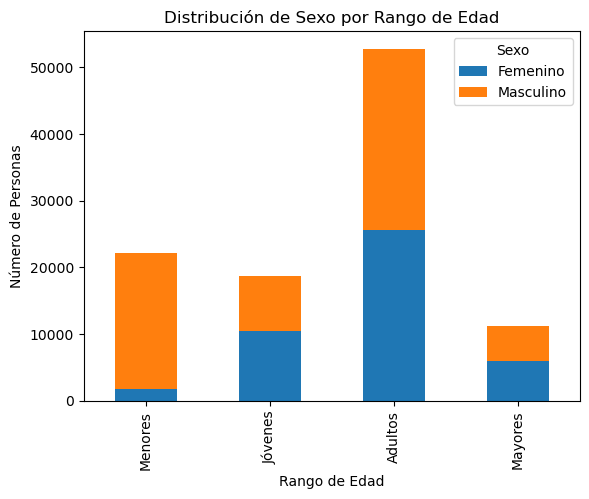

In [57]:
#Agrupamos los datos por rango de edad y sexo y contamos el número de personas en cada categoría
agrupado = cardex_total.groupby(['Rango de Edad', 'Sexo']).size().unstack()

#Creamos un gráfico de barras apiladas
agrupado.plot(kind='bar', stacked=True)

#Etiquetas y título del gráfico
plt.xlabel('Rango de Edad')
plt.ylabel('Número de Personas')
plt.title('Distribución de Sexo por Rango de Edad')

#Mostramos el gráfico
plt.show()

In [58]:
#Se guardan los valores 'Menores' en una variable
data = cardex_total[cardex_total['Edad'] == 0]
data

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad,Rango de Edad
4,2015,10449,2,Masculino,NaN,NaN,ES,ES,2016.0,0.0,Menores
29,2015,10502,14,Masculino,NaN,NaN,ES,ES,2016.0,0.0,Menores
69,2015,10539,1,Masculino,NaN,NaN,NaN,ES,2016.0,0.0,Menores
72,2015,10541,1,Masculino,NaN,NaN,ES,ES,2016.0,0.0,Menores
73,2015,10541,1,Masculino,NaN,NaN,ES,ES,2016.0,0.0,Menores
...,...,...,...,...,...,...,...,...,...,...,...
110708,2022,5886,2,Masculino,NaN,NaN,ES,ES,2022.0,0.0,Menores
110713,2022,6564,1,Masculino,NaN,NaN,FR,FR,2022.0,0.0,Menores
110714,2022,6564,1,Masculino,NaN,NaN,FR,FR,2022.0,0.0,Menores
110735,2022,6850,1,Masculino,NaN,NaN,ES,ES,2022.0,0.0,Menores


In [59]:
#Calculamos el recuento de clientes por género
conteo_genero = cardex_total['Sexo'].value_counts()

#Calculamos el porcentaje de cada categoría de género
porcentaje_genero = (conteo_genero / len(cardex_total)) * 100

#Creamos un nuevo DataFrame con el recuento y el porcentaje
resumen_genero = pd.DataFrame({'Recuento': conteo_genero, 'Porcentaje': porcentaje_genero})

#Mostramos el resumen
print(resumen_genero)

           Recuento  Porcentaje
Masculino     61185   58.387648
Femenino      43606   41.612352


In [60]:
#Repartimos los datos aleatoriamente entre la variable 'Sexo'
muestra_aleatoria = np.random.choice(['Masculino','Femenino'], size=len(data), p=[0.5,0.5], replace=True)
muestra_aleatoria

array(['Femenino', 'Masculino', 'Masculino', ..., 'Femenino', 'Femenino',
       'Masculino'], dtype='<U9')

In [61]:
#Se sustituyen los valores nuevos en el cardex
cardex_total.loc[cardex_total['Edad'] == 0, 'Sexo'] = muestra_aleatoria

In [62]:
#Se muestran como están repartidos los nuevos valores para los de edad indefinida
cardex_total[(cardex_total['Edad'] == 0)].value_counts('Sexo')

Sexo
Masculino    9392
Femenino     9364
dtype: int64

In [63]:
#Se muestran como están repartidos los nuevos valores para los menores
cardex_total[(cardex_total['Rango de Edad'] == 'Menores')].value_counts('Sexo')

Sexo
Masculino    11121
Femenino     11029
dtype: int64

In [64]:
#Se muestran como están repartidos los nuevos valores en general
cardex_total.value_counts('Sexo')

Sexo
Femenino     52916
Masculino    51875
dtype: int64

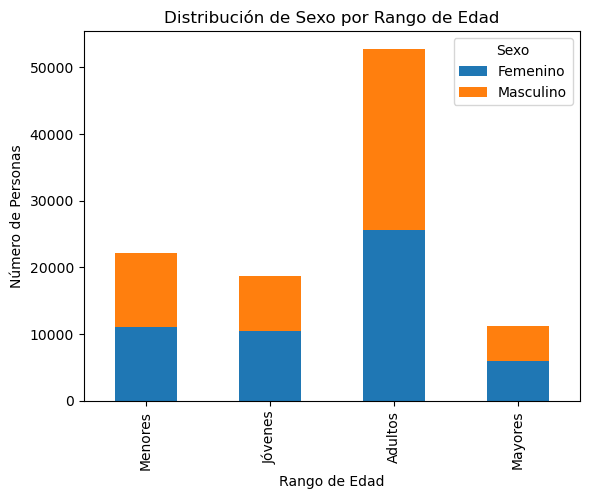

In [65]:
#Agrupamos los datos por rango de edad y sexo y contamos el número de personas en cada categoría
agrupado = cardex_total.groupby(['Rango de Edad', 'Sexo']).size().unstack()

#Creamos un gráfico de barras apiladas
agrupado.plot(kind='bar', stacked=True)

#Etiquetas y título del gráfico
plt.xlabel('Rango de Edad')
plt.ylabel('Número de Personas')
plt.title('Distribución de Sexo por Rango de Edad')

#Mostramos el gráfico
plt.show()

In [66]:
#Comprobamos los nulos de nuevo
cardex_total.isnull().sum()

Año                                  0
Reserva                              0
Desglose                             0
Sexo                                 0
Provincia residencia             34139
Comunidad autónoma residencia    34191
País residencia                   3685
Nacionalidad                      2409
Año de nacimiento                    0
Edad                                 0
Rango de Edad                        0
dtype: int64

In [67]:
#Rellenamos los nulos de Nacionalidad y País de residencia con españoles
cardex_total['País residencia'] = cardex_total['País residencia'].fillna('ES')
cardex_total['Nacionalidad'] = cardex_total['Nacionalidad'].fillna('ES')
cardex_total

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad,Rango de Edad
0,2015,10449,1,Femenino,20.0,PVA,ES,ES,1971.0,45.0,Adultos
1,2015,10449,1,Masculino,NaN,NaN,ES,ES,1970.0,46.0,Adultos
2,2015,10449,2,Masculino,NaN,NaN,ES,ES,1970.0,46.0,Adultos
3,2015,10449,2,Femenino,20.0,PVA,ES,ES,1971.0,45.0,Adultos
4,2015,10449,2,Femenino,NaN,NaN,ES,ES,2016.0,0.0,Menores
...,...,...,...,...,...,...,...,...,...,...,...
110760,2022,6866,1,Masculino,NaN,NaN,ES,ES,1993.0,29.0,Jóvenes
110761,2022,6867,1,Masculino,14.0,AND,ES,ES,1960.0,62.0,Adultos
110762,2022,6867,1,Femenino,NaN,NaN,ES,ES,1970.0,52.0,Adultos
110763,2022,6858,1,Masculino,29.0,AND,ES,ES,1983.0,39.0,Adultos


In [68]:
#Calculamos el número de nulos de provincia de residencia para españoles
num_nulos_provincia=len(cardex_total[(cardex_total['Provincia residencia'].isnull()) & (cardex_total['País residencia'] == 'ES')])
num_nulos_provincia

31131

In [69]:
#Guardamos la distribución de provincias no nulas
provincia_no_null=cardex_total['Provincia residencia'].dropna()

In [70]:
#Elegimos valores aleatorios siguiendo la distribución recién guardada con la longitud de nulos
valores_nulos_provincia = np.random.choice(provincia_no_null, size=num_nulos_provincia, replace=True)
valores_nulos_provincia

array([28.,  6., 41., ..., 10., 14.,  6.])

In [71]:
#Asignamos estos valores aleatorios a los nulos residentes en España
cardex_total.loc[(cardex_total['Provincia residencia'].isnull()) & (cardex_total['País residencia'] == 'ES'), 'Provincia residencia'] = valores_nulos_provincia

In [72]:
#Comprobamos los valores de la provincia de residencia
cardex_total['Provincia residencia'].value_counts()

6.0     29954
41.0    25459
10.0    11683
28.0     9357
14.0     5481
37.0     2693
23.0     2229
21.0     2151
45.0     1671
29.0     1523
11.0     1155
18.0     1073
47.0      950
8.0       516
5.0       426
13.0      416
49.0      384
24.0      367
33.0      335
19.0      335
9.0       270
50.0      261
15.0      254
48.0      217
31.0      202
20.0      201
46.0      176
40.0      176
34.0      175
30.0      172
3.0       156
4.0       144
1.0       143
2.0       132
42.0      122
26.0      120
36.0      112
39.0       90
16.0       69
32.0       69
43.0       60
27.0       50
35.0       46
7.0        36
22.0       34
38.0       32
51.0       29
52.0       20
17.0       19
44.0       16
25.0       11
12.0       11
Name: Provincia residencia, dtype: int64

In [73]:
cardex_total.isnull().sum()

Año                                  0
Reserva                              0
Desglose                             0
Sexo                                 0
Provincia residencia              3008
Comunidad autónoma residencia    34191
País residencia                      0
Nacionalidad                         0
Año de nacimiento                    0
Edad                                 0
Rango de Edad                        0
dtype: int64

In [74]:
#Comprobamos que estos nulos son de extranjeros
cardex_total[(cardex_total['Provincia residencia'].isnull())]

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad,Rango de Edad
34,2015,10523,1,Masculino,NaN,NaN,PT,PT,1952.0,64.0,Adultos
35,2015,10523,1,Femenino,NaN,NaN,PT,PT,1957.0,59.0,Adultos
36,2015,10523,2,Masculino,NaN,NaN,PT,PT,1951.0,65.0,Mayores
37,2015,10523,2,Femenino,NaN,NaN,PT,PT,1955.0,61.0,Adultos
38,2015,10523,3,Masculino,NaN,NaN,PT,PT,1933.0,83.0,Mayores
...,...,...,...,...,...,...,...,...,...,...,...
110577,2022,6580,12,Masculino,NaN,NaN,PY,PY,1997.0,25.0,Jóvenes
110638,2022,6862,1,Masculino,NaN,NaN,SE,SE,2022.0,0.0,Menores
110639,2022,6862,1,Masculino,NaN,NaN,SE,SE,2022.0,0.0,Menores
110713,2022,6564,1,Femenino,NaN,NaN,FR,FR,2022.0,0.0,Menores


In [75]:
#Asignamos el valor Extranjero a los nulos
cardex_total['Provincia residencia'] = cardex_total['Provincia residencia'].fillna('Extranjera')

In [76]:
# Creamos un diccionario de mapeo de provincias a comunidades autónomas
mapeo_provincia_comunidad = {
    4: 'AND',
    11: 'AND',
    14: 'AND',
    18: 'AND',
    21: 'AND',
    23: 'AND',
    29: 'AND',
    41: 'AND',
    22: 'ARA',
    44: 'ARA',
    50: 'ARA',
    33: 'AST',
    39: 'CAN',
    8: 'CAT',
    17: 'CAT',
    25: 'CAT',
    43: 'CAT',
    5: 'CLL',
    9: 'CLL',
    24: 'CLL',
    34: 'CLL',
    37: 'CLL',
    40: 'CLL',
    42: 'CLL',
    47: 'CLL',
    49: 'CLL',
    2: 'CMA',
    13: 'CMA',
    16: 'CMA',
    19: 'CMA',
    45: 'CMA',
    30: 'CMU',
    3: 'CVA',
    12: 'CVA',
    46: 'CVA',
    51: 'CYM',
    52: 'CYM',
    6: 'EXT',
    10: 'EXT',
    15: 'GAL',
    27: 'GAL',
    32: 'GAL',
    36: 'GAL',
    7: 'IBA',
    35: 'ICA',
    38: 'ICA',
    28: 'MAD',
    31: 'NAV',
    1: 'PVA',
    20: 'PVA',
    48: 'PVA',
    26: 'RIO',
    'Extranjera': 'Extranjera'
}

#Aplicamos el mapeo al DataFrame utilizando la columna 'Provincia residencia' para obtener la columna 'Comunidad autónoma residencia'
cardex_total['Comunidad autónoma residencia'] = cardex_total['Provincia residencia'].map(mapeo_provincia_comunidad)

In [77]:
#Creamos un diccionario de mapeo de los nombres de las provincias
mapeo_provincia_nombre = {
    4: 'ALM',
    11: 'CAD',
    14: 'COR',
    18: 'GRA',
    21: 'HLV',
    23: 'JAE',
    29: 'MAL',
    41: 'SEV',
    22: 'HSC',
    44: 'TER',
    50: 'ZAR',
    33: 'AST',
    39: 'CAN',
    8: 'BAR',
    17: 'GER',
    25: 'LER',
    43: 'TAR',
    5: 'AVI',
    9: 'BUR',
    24: 'LEO',
    34: 'PAL',
    37: 'SAL',
    40: 'SEG',
    42: 'SOR',
    47: 'VAD',
    49: 'ZAM',
    2: 'ALB',
    13: 'CRE',
    16: 'CUE',
    19: 'GUA',
    45: 'TOL',
    30: 'MUR',
    3: 'ALI',
    12: 'CAS',
    46: 'VAL',
    51: 'CEU',
    52: 'MEL',
    6: 'BAD',
    10: 'CAC',
    15: 'COR',
    27: 'LUG',
    32: 'ORE',
    36: 'PON',
    7: 'IBA',
    35: 'LPA',
    38: 'SCT',
    28: 'MAD',
    31: 'NAV',
    1: 'ALA',
    20: 'GUI',
    48: 'VIZ',
    26: 'RIO',
    'Extranjera': 'Extranjera'
}

#Aplicarmos el mapeo al DataFrame utilizando la columna 'Provincia residencia'
cardex_total['Provincia residencia'] = cardex_total['Provincia residencia'].map(mapeo_provincia_nombre)

In [78]:
#Comprobamos que no hay nulos
cardex_total.isnull().sum()

Año                              0
Reserva                          0
Desglose                         0
Sexo                             0
Provincia residencia             0
Comunidad autónoma residencia    0
País residencia                  0
Nacionalidad                     0
Año de nacimiento                0
Edad                             0
Rango de Edad                    0
dtype: int64

In [79]:
# Guardamos el dataframe en un nuevo archivo CSV
cardex_total.to_csv("Outputs/cardex_total_preprocesado.csv", index=False)

## Análisis exploratorio

In [80]:
#Leemos el csv para recuperar el dataframe de reservas preprocesado
reservas_total = pd.read_csv('Outputs/reservas_total_preprocesado.csv')
reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
0,0,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC,MPC,...,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September,326
1,0,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC,MPC,...,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September,326
2,1,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November,313
3,0,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November,233
4,0,2015,10539.0,1,2016-07-08,2,EC,EC,PC,PC,...,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,1,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC,PC,...,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November,271
51912,1,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC,PC,...,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November,243
51913,1,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC,PC,...,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November,227
51914,1,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC,MPC,...,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October,295


In [81]:
#Leemos el csv para recuperar el dataframe de cardex preprocesado
cardex_total = pd.read_csv('Outputs/cardex_total_preprocesado.csv')
cardex_total

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad,Rango de Edad
0,2015,10449,1,Femenino,GUI,PVA,ES,ES,1971.0,45.0,Adultos
1,2015,10449,1,Masculino,MAD,MAD,ES,ES,1970.0,46.0,Adultos
2,2015,10449,2,Masculino,BAD,EXT,ES,ES,1970.0,46.0,Adultos
3,2015,10449,2,Femenino,GUI,PVA,ES,ES,1971.0,45.0,Adultos
4,2015,10449,2,Femenino,SEV,AND,ES,ES,2016.0,0.0,Menores
...,...,...,...,...,...,...,...,...,...,...,...
104786,2022,6866,1,Masculino,COR,AND,ES,ES,1993.0,29.0,Jóvenes
104787,2022,6867,1,Masculino,COR,AND,ES,ES,1960.0,62.0,Adultos
104788,2022,6867,1,Femenino,BAD,EXT,ES,ES,1970.0,52.0,Adultos
104789,2022,6858,1,Masculino,MAL,AND,ES,ES,1983.0,39.0,Adultos


In [82]:
#Unimos reservas_total y cardex_total utilizando un "inner join" por las columnas en común (Año, reserva y desglose)
df_cardex_reservas = pd.merge(cardex_total, reservas_total, on=["Año", "Reserva", "Desglose"], how="inner")
df_cardex_reservas

,Año,Reserva,Desglose,Sexo,Provincia residencia,Comunidad autónoma residencia,País residencia,Nacionalidad,Año de nacimiento,Edad,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
0,2015,10449,1,Femenino,GUI,PVA,ES,ES,1971.0,45.0,...,767.40,35.70,0.00,89.22,Tarde,2,2,August,September,326
1,2015,10449,1,Masculino,MAD,MAD,ES,ES,1970.0,46.0,...,767.40,35.70,0.00,89.22,Tarde,2,2,August,September,326
2,2015,10449,2,Masculino,BAD,EXT,ES,ES,1970.0,46.0,...,767.40,35.70,0.00,89.22,Tarde,3,2,August,September,326
3,2015,10449,2,Femenino,GUI,PVA,ES,ES,1971.0,45.0,...,767.40,35.70,0.00,89.22,Tarde,3,2,August,September,326
4,2015,10449,2,Femenino,SEV,AND,ES,ES,2016.0,0.0,...,767.40,35.70,0.00,89.22,Tarde,3,2,August,September,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94933,2022,6866,1,Masculino,COR,AND,ES,ES,1993.0,29.0,...,171.73,9.17,22.93,22.93,Mañana,2,1,September,September,1
94934,2022,6867,1,Masculino,COR,AND,ES,ES,1960.0,62.0,...,96.00,0.00,0.00,0.00,Tarde,2,1,September,September,0
94935,2022,6867,1,Femenino,BAD,EXT,ES,ES,1970.0,52.0,...,96.00,0.00,0.00,0.00,Tarde,2,1,September,September,0
94936,2022,6858,1,Masculino,MAL,AND,ES,ES,1983.0,39.0,...,153.88,0.00,0.00,0.00,Tarde,2,1,September,September,1


In [83]:
# Guardamos el dataframe en un nuevo archivo CSV
df_cardex_reservas.to_csv("Outputs/df_cardex_reservas.csv", index=False)

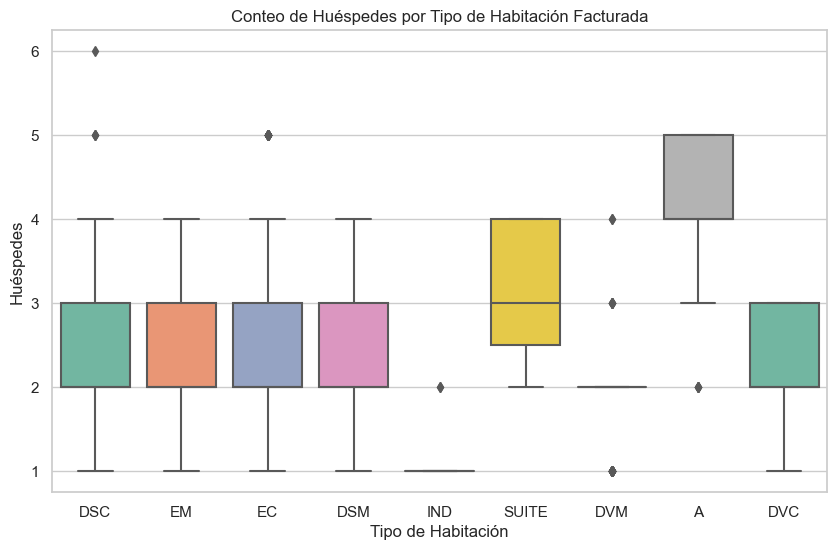

In [84]:
#Dibujamos el boxplot de huéspedes por tipo de habitación
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.set(style="whitegrid")  # Estilo del gráfico

sns.boxplot(x='Tip.Hab.Fra.', y='Huespedes', data=reservas_total, palette='Set2')

#Título y etiquetas
plt.title('Conteo de Huéspedes por Tipo de Habitación Facturada')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Huéspedes')

#Mostramos el gráfico
plt.show()

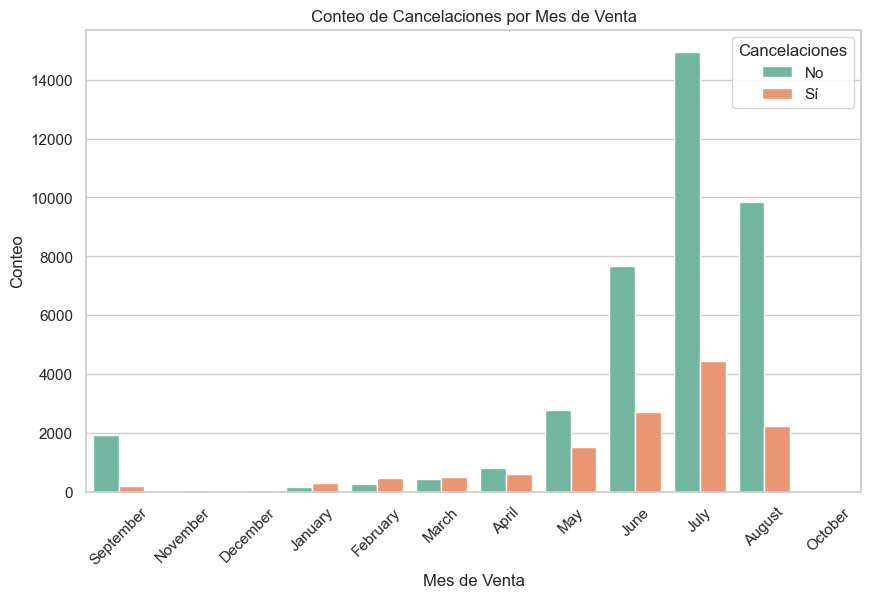

In [85]:
#Dibujamos el gráfico de cancelaciones por mes de venta
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.set(style="whitegrid")  # Estilo del gráfico

sns.countplot(x='Mes Venta', hue='Estado reserva', data=reservas_total, palette='Set2')

#Título y etiquetas
plt.title('Conteo de Cancelaciones por Mes de Venta')
plt.xlabel('Mes de Venta')
plt.ylabel('Conteo')
plt.legend(title='Cancelaciones', labels=['No', 'Sí'])  # Leyenda

plt.xticks(rotation=45)

#Mostramos el gráfico
plt.show()

In [86]:
#Ordenamos el porcentaje de cancelaciones por mes de venta
reservas_total.groupby(['Mes Venta']).mean().sort_values(['Estado reserva'],ascending=False)

,Estado reserva,Año,Reserva,Desglose,Noches,AD,NI,CU,Precio total,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Huespedes,Cantidad Habitaciones,Antelacion
Mes Venta,,,,,,,,,,,,,,,,
October,0.800000,2018.250000,7726.350000,1.300000,6.350000,1.950000,0.300000,0.150000,1030.245498,918.892498,25.309500,32.684500,46.109000,2.400000,1.600000,264.850000
January,0.672811,2018.161290,6621.341014,1.193548,5.442396,2.186636,0.232719,0.064516,806.985796,666.077824,28.309009,50.555023,53.518594,2.483871,1.387097,177.460829
November,0.666667,2018.397436,7916.102564,1.269231,4.025641,2.205128,0.128205,0.076923,663.694531,529.696583,24.806795,58.095128,42.762692,2.410256,1.500000,235.500000
February,0.638587,2019.304348,453.960598,1.197011,5.130435,2.225543,0.232337,0.050272,808.205646,674.401611,28.959443,42.988628,54.250666,2.508152,1.394022,151.342391
December,0.617647,2017.794118,8229.735294,1.147059,5.544118,2.279412,0.147059,0.044118,739.126325,619.041178,24.319265,49.386176,39.541471,2.470588,1.294118,216.308824
March,0.548872,2018.941998,478.876477,1.177229,5.215897,2.198711,0.177229,0.074114,799.762902,667.118777,29.027540,44.348453,52.052771,2.450054,1.354458,120.617615
April,0.431737,2018.443174,807.656183,1.218728,5.065046,2.240172,0.177269,0.074339,745.848519,619.214281,27.207848,42.330029,50.203939,2.491780,1.437455,88.646891
May,0.351873,2018.799162,1577.665581,1.225041,4.641145,2.217826,0.209448,0.092157,694.857039,569.881646,25.907293,43.569206,47.890095,2.519432,1.448685,54.799395
June,0.260397,2018.877936,2839.721409,1.184732,3.925683,2.202926,0.195322,0.091644,589.595951,485.564486,22.073363,35.454262,40.141691,2.489892,1.368887,27.849634


In [87]:
#Sacamos la tabla de frecuencias de rango de edad por comunidad autónoma de residencia
tabla_frecuencias = pd.crosstab(cardex_total['Comunidad autónoma residencia'], cardex_total['Rango de Edad'])
tabla_frecuencias

Rango de Edad,Adultos,Jóvenes,Mayores,Menores
Comunidad autónoma residencia,,,,
AND,19443,7282,4364,8126
ARA,181,43,25,62
AST,186,41,46,62
CAN,55,8,10,17
CAT,293,75,118,120
CLL,3035,867,477,1184
CMA,1392,560,142,529
CMU,100,37,8,27
CVA,156,27,94,66


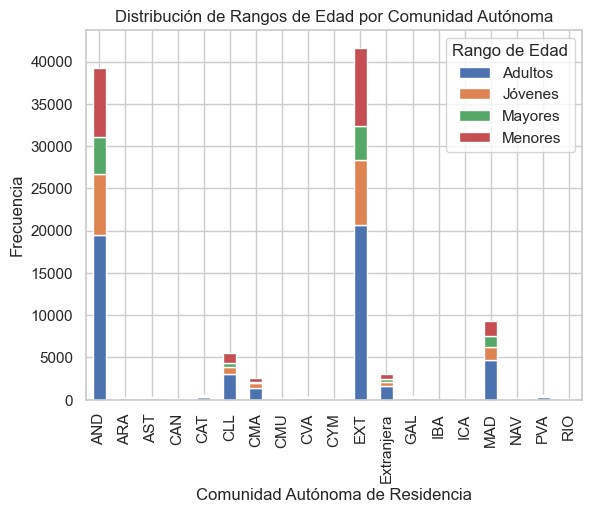

In [88]:
#Dibujamos la frecuencia de rango de edad por comunidad autónoma de residencia
tabla_frecuencias.plot(kind='bar', stacked=True)
plt.xlabel('Comunidad Autónoma de Residencia')
plt.ylabel('Frecuencia')
plt.title('Distribución de Rangos de Edad por Comunidad Autónoma')
plt.legend(title='Rango de Edad')
plt.show()

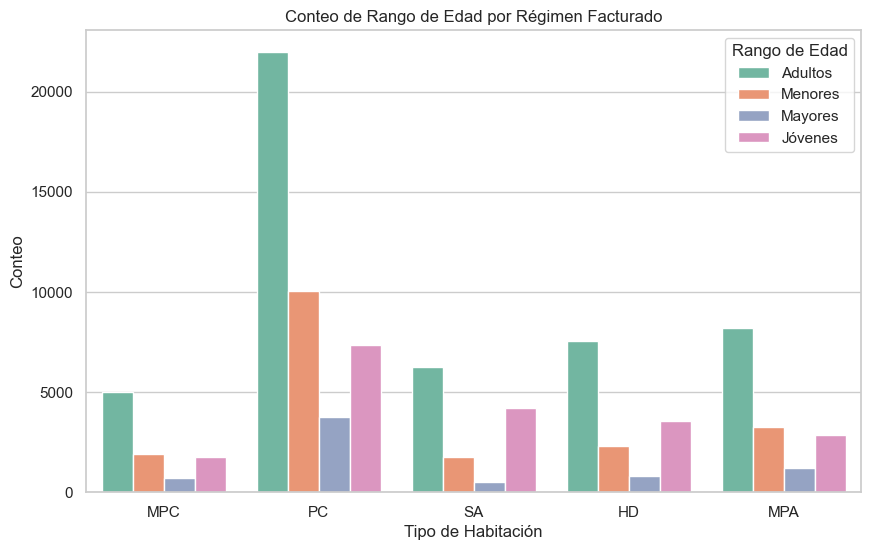

In [89]:
#Dibujamos el gráfico de rango de edad por régimen
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.set(style="whitegrid")  # Estilo del gráfico

sns.countplot(x='Régimen factura', hue='Rango de Edad', data=df_cardex_reservas, palette='Set2')

#Título y etiquetas
plt.title('Conteo de Rango de Edad por Régimen Facturado')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Conteo')

#Mostramos el gráfico
plt.show()

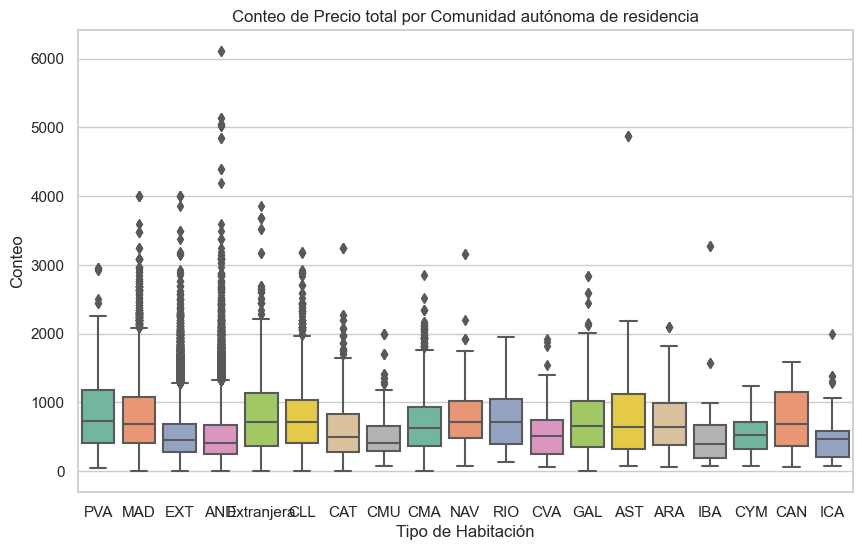

In [90]:
#Mostramos el gráfico de precio total de la reserva por CCAA de residencia
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.set(style="whitegrid")  # Estilo del gráfico

sns.boxplot(x='Comunidad autónoma residencia', y='Precio total', data=df_cardex_reservas, palette='Set2')

#Título y etiquetas
plt.title('Conteo de Precio total por Comunidad autónoma de residencia')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Conteo')

#Mostramos el gráfico
plt.show()

In [91]:
#Vemos las reservas de precio superior a 5000
df_cardex_reservas[df_cardex_reservas['Precio total'] > 5000]['Precio total']

14975    5025.99993
14976    5025.99993
16941    5132.99985
16942    5132.99985
28302    6107.99985
28303    6107.99985
28747    5049.99997
28748    5049.99997
Name: Precio total, dtype: float64

# Modelos de predicción

## Regresión logística

In [92]:
#Función para dibujar la curva_roc a partir de y_test y la predicción de y_test
def curva_roc(y_test, y_test_pred_prob):
    preds = y_test_pred_prob
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(10,7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [93]:
#Función que recibe dos distribuciones de probabilidad y las representa en un histograma doble
def represento_doble_hist(x_1, x_0, n_bins=20, title='', label_1='Clase 1',
                          label_0='Clase 0', density=1):
    bins = n_bins
    plt.hist(x_1, bins, density=density, alpha=0.5, label=label_1, color='red')
    plt.hist(x_0, bins, density=density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')

In [94]:
#Función que imprime las métricas del modelo a partir de un umbral, la y_test y la predicción de y_test
def metricas(umbral, y_test, y_test_pred_prob):
    y_umbralizadas = (y_test_pred_prob > umbral)
    print(u"Umbral:", round(umbral,2))
    print(u"\nMatriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas),2)))
    print(u"Precision\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas),2)))
    print("Recall\t\t{}\n".format(round(metrics.recall_score(y_test, y_umbralizadas),2)))
    print(u'F1-score\t{}\n\n'.format(round(metrics.f1_score(y_test, y_umbralizadas),2)))

In [95]:
# Elegimos las variables que usaremos en el modelo
columnas_X = ['Noches', 'Tip.Hab.Fra.', 'Régimen factura', 'AD', 'NI', 'CU', 'Horario venta',
            'Precio alojamiento', 'Precio desayuno', 'Precio almuerzo', 'Precio cena',
            'Cantidad Habitaciones', 'Mes Entrada', 'Mes Venta', 'Antelacion']

#Dividimos en X e y
X = reservas_total[columnas_X]
y = reservas_total['Estado reserva']
y

0        0
1        0
2        1
3        0
4        0
        ..
51911    1
51912    1
51913    1
51914    1
51915    1
Name: Estado reserva, Length: 51916, dtype: int64

In [96]:
#Comprobamos que no hay nulos
X.isnull().sum()

Noches                   0
Tip.Hab.Fra.             0
Régimen factura          0
AD                       0
NI                       0
CU                       0
Horario venta            0
Precio alojamiento       0
Precio desayuno          0
Precio almuerzo          0
Precio cena              0
Cantidad Habitaciones    0
Mes Entrada              0
Mes Venta                0
Antelacion               0
dtype: int64

In [97]:
X.dtypes

Noches                     int64
Tip.Hab.Fra.              object
Régimen factura           object
AD                         int64
NI                         int64
CU                         int64
Horario venta             object
Precio alojamiento       float64
Precio desayuno          float64
Precio almuerzo          float64
Precio cena              float64
Cantidad Habitaciones      int64
Mes Entrada               object
Mes Venta                 object
Antelacion                 int64
dtype: object

In [98]:
#One Hot Encoding de las variables categóricas
X =  pd.get_dummies(X, columns=["Tip.Hab.Fra.", "Régimen factura", "Horario venta", "Mes Entrada", "Mes Venta"], drop_first=True)
X

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
0,6,2,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
1,6,3,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
2,4,2,0,0,416.16000,0.00,0.00,0.00,1,313,...,0,0,0,0,0,0,0,1,0,0
3,6,3,0,0,455.52000,24.00,59.94,59.94,4,233,...,0,0,0,0,0,0,0,1,0,0
4,2,3,0,0,173.37000,9.12,22.80,22.80,1,221,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,3,2,0,0,344.43999,18.51,46.29,46.29,1,271,...,0,0,0,0,0,0,0,1,0,0
51912,3,2,1,0,563.83500,30.06,75.18,75.18,1,243,...,0,0,0,0,0,0,0,1,0,0
51913,3,2,1,0,322.26000,17.37,43.41,43.41,1,227,...,0,0,0,0,0,0,0,1,0,0
51914,7,2,0,0,1275.31999,60.13,0.00,150.29,2,295,...,0,0,0,0,0,0,0,0,1,0


In [99]:
X.columns

Index(['Noches', 'AD', 'NI', 'CU', 'Precio alojamiento', 'Precio desayuno',
       'Precio almuerzo', 'Precio cena', 'Cantidad Habitaciones', 'Antelacion',
       'Tip.Hab.Fra._DSC', 'Tip.Hab.Fra._DSM', 'Tip.Hab.Fra._DVC',
       'Tip.Hab.Fra._DVM', 'Tip.Hab.Fra._EC', 'Tip.Hab.Fra._EM',
       'Tip.Hab.Fra._IND', 'Tip.Hab.Fra._SUITE', 'Régimen factura_MPA',
       'Régimen factura_MPC', 'Régimen factura_PC', 'Régimen factura_SA',
       'Horario venta_Mañana', 'Horario venta_Noche', 'Horario venta_Tarde',
       'Mes Entrada_July', 'Mes Entrada_June', 'Mes Entrada_September',
       'Mes Venta_August', 'Mes Venta_December', 'Mes Venta_February',
       'Mes Venta_January', 'Mes Venta_July', 'Mes Venta_June',
       'Mes Venta_March', 'Mes Venta_May', 'Mes Venta_November',
       'Mes Venta_October', 'Mes Venta_September'],
      dtype='object')

In [100]:
# Guardamos el dataframe X en un nuevo archivo CSV
X.to_csv("Outputs/X.csv", index=False)

In [101]:
# Guardamos el dataframe y en un nuevo archivo CSV
y.to_csv("Outputs/y.csv", index=False)

In [102]:
#Comprobamos algunas de las columnas con valores extremos
X[["Noches", "Precio alojamiento", "Cantidad Habitaciones", "Antelacion"]].describe()

,Noches,Precio alojamiento,Cantidad Habitaciones,Antelacion
count,51916.000000,51916.000000,51916.000000,51916.000000
mean,3.775195,470.304547,1.307651,27.691213
std,2.269985,333.798620,0.644077,35.730191
min,1.000000,-37.500000,1.000000,0.000000
25%,2.000000,236.697500,1.000000,6.000000
50%,3.000000,386.415000,1.000000,16.000000
75%,5.000000,613.740000,1.000000,34.000000
max,61.000000,8208.030070,5.000000,326.000000


In [103]:
#Inicializamos el escalador robusto. Este escalador es resistente a los valores atípicos y se basa en la mediana y el rango intercuartílico
#en lugar de la media y la desviación estándar. Es útil cuando los datos contienen valores extremos,
#como es el caso de las Columnas "Precio alojamiento" y "Antelacion"
robust_scaler = RobustScaler()

In [104]:
#Aplicamos el escalador
X[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X[["Precio alojamiento", "Antelacion"]])

X[["Precio alojamiento", "Antelacion"]].describe()

,Precio alojamiento,Antelacion
count,5.191600e+04,51916.000000
mean,2.224936e-01,0.417543
std,8.853077e-01,1.276078
min,-1.124316e+00,-0.571429
25%,-3.970839e-01,-0.357143
50%,7.537916e-17,0.000000
75%,6.029161e-01,0.642857
max,2.074465e+01,11.071429


In [105]:
#Inicializamos el escalador Min-Max
scaler = MinMaxScaler()

In [106]:
#Aplicamos la normalización
X_norm = scaler.fit_transform(X)

In [107]:
#Dividimos el conjunto normalizado de datos en entrenamiento, prueba y validación
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [108]:
#Definimos el modelo de regresión logística y los parámetros
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
              "class_weight":['balanced', None]}

In [109]:
#Optimizamos la mejor división del dataset para realizar la validación
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [110]:
#Imprimimos el modelo con mejores parámetros
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_, 2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.71


In [111]:
#Definimos la regresión logística con los mejores parámetros
reg_log =  LogisticRegression(C=modelo_gs.best_params_['C'],
                              class_weight=modelo_gs.best_params_['class_weight'])

In [112]:
#Ajustamos el modelo a nuestros datos de entrenamiento
reg_log.fit(X_train, y_train)

LogisticRegression(C=0.09, class_weight='balanced')

In [113]:
#Obtenemos las predicciones de y_test a partir de x_test
y_test_pred_prob = reg_log.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

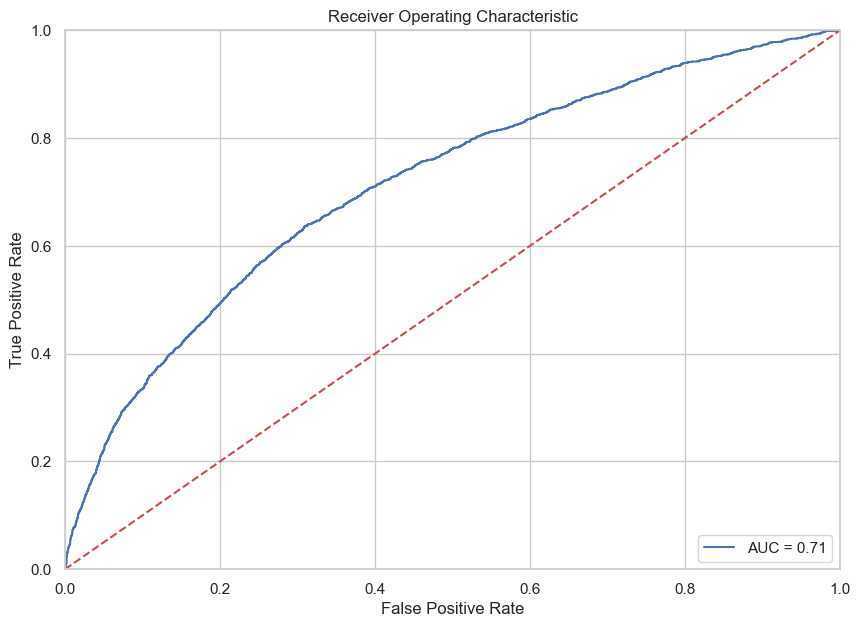

In [114]:
#Dibujamos las tasas de positivos verdaderos y falsos según el umbral que escojamos
curva_roc(y_test, y_test_pred_prob[:, 1])

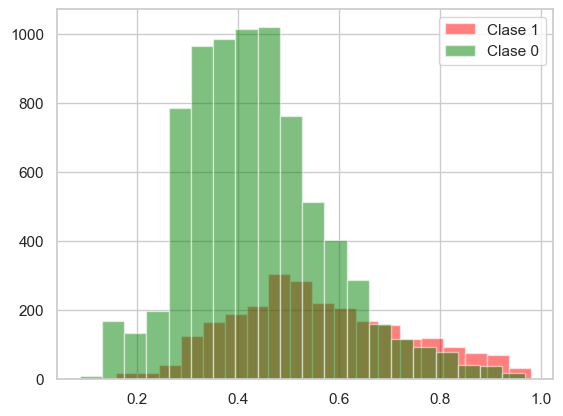

In [115]:
#Representamos las probabilidades que asigna el modelo a los datos que son 0s y en rojo las probabilidades asignadas a los datos que son 1s.
#Comprobamos que efectivamente en este cluster existe muy poca correlación
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=20, density=0)

In [117]:
#Mostramos las métricas según los diferentes umbrales
for umbral in np.arange(0.4, 0.55, 0.05):
    metricas(umbral, y_test, y_test_pred_prob[:, 1])

Umbral: 0.4

Matriz de confusión
 [[3375 4404]
 [ 477 2128]]

Accuracy	0.53
Precision	0.33
Recall		0.82

F1-score	0.47


Umbral: 0.45

Matriz de confusión
 [[4480 3299]
 [ 707 1898]]

Accuracy	0.61
Precision	0.37
Recall		0.73

F1-score	0.49


Umbral: 0.5

Matriz de confusión
 [[5627 2152]
 [1047 1558]]

Accuracy	0.69
Precision	0.42
Recall		0.6

F1-score	0.49


Umbral: 0.55

Matriz de confusión
 [[6331 1448]
 [1380 1225]]

Accuracy	0.73
Precision	0.46
Recall		0.47

F1-score	0.46




In [118]:
#Guardamos el modelo ya entrenado en un archivo
joblib.dump(reg_log, 'Outputs/logistic_regresion.pkl')

['Outputs/logistic_regresion.pkl']

## KNN

In [119]:
#Leemos el csv para recuperarlo
X = pd.read_csv('Outputs/X.csv')
X

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
0,6,2,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
1,6,3,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
2,4,2,0,0,416.16000,0.00,0.00,0.00,1,313,...,0,0,0,0,0,0,0,1,0,0
3,6,3,0,0,455.52000,24.00,59.94,59.94,4,233,...,0,0,0,0,0,0,0,1,0,0
4,2,3,0,0,173.37000,9.12,22.80,22.80,1,221,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,3,2,0,0,344.43999,18.51,46.29,46.29,1,271,...,0,0,0,0,0,0,0,1,0,0
51912,3,2,1,0,563.83500,30.06,75.18,75.18,1,243,...,0,0,0,0,0,0,0,1,0,0
51913,3,2,1,0,322.26000,17.37,43.41,43.41,1,227,...,0,0,0,0,0,0,0,1,0,0
51914,7,2,0,0,1275.31999,60.13,0.00,150.29,2,295,...,0,0,0,0,0,0,0,0,1,0


In [120]:
#Leemos el csv para recuperarlo
y = pd.read_csv('Outputs/y.csv')
y

,Estado reserva
0,0
1,0
2,1
3,0
4,0
...,...
51911,1
51912,1
51913,1
51914,1


In [121]:
#Inicializamos el escalador robusto
robust_scaler = RobustScaler()

In [122]:
#Aplicamos el escalador
X[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X[["Precio alojamiento", "Antelacion"]])

In [123]:
#Inicializamos el escalador Min-Max
scaler = MinMaxScaler()

In [124]:
#Aplicamos la normalización
X_norm = scaler.fit_transform(X)

In [125]:
#Dividimos el conjunto normalizado de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [126]:
#Definimos el modelo KNN
KNN_model=KNeighborsClassifier(n_neighbors=20)

In [127]:
#Ajustamos el modelo a nuestros datos de entrenamiento
regressor = KNN_model.fit(X_train,y_train)

In [128]:
#Obtenemos las predicciones de y_test a partir de x_test
y_test_pred_prob = KNN_model.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

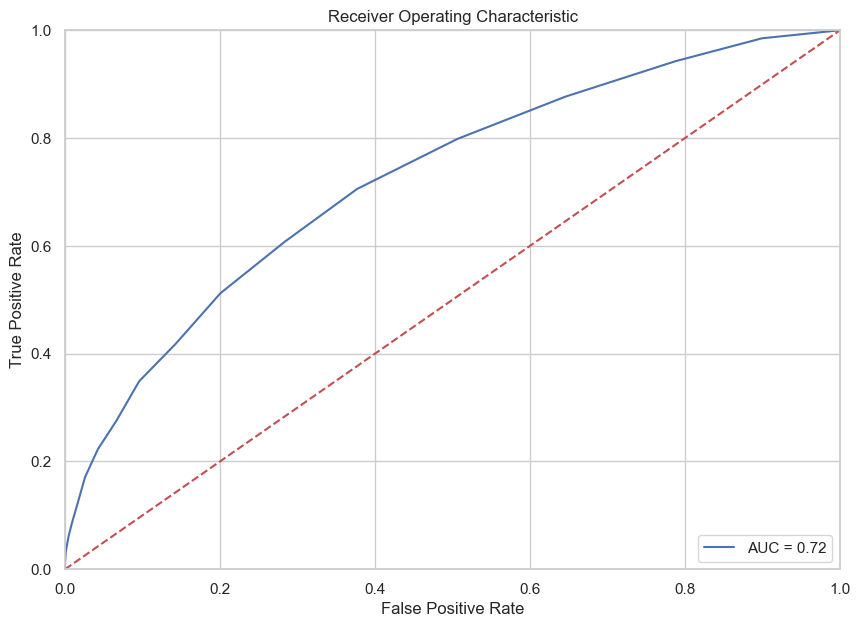

In [129]:
#Dibujamos las tasas de positivos verdaderos y falsos según el umbral que escojamos
curva_roc(y_test, y_test_pred_prob[:,1])

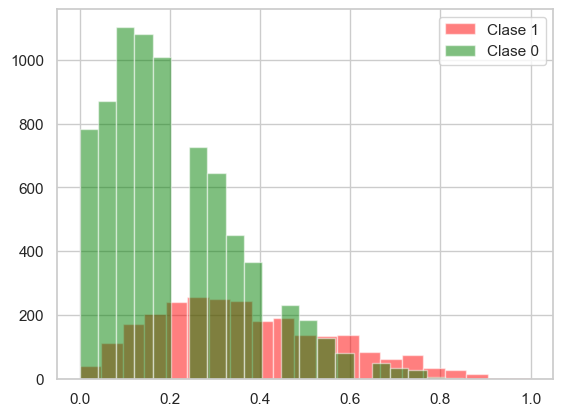

In [130]:
#Representamos las probabilidades que asigna el modelo a los datos que son 0s y en rojo las probabilidades asignadas a los datos que son 1s.
#Comprobamos que efectivamente en este cluster hay poca correlación
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

In [131]:
#Mostramos las métricas según los diferentes umbrales
for umbral in np.arange(0.1, 0.5, 0.05):
    metricas(umbral, y_test, y_test_pred_prob[:, 1])

Umbral: 0.1

Matriz de confusión
 [[2757 5022]
 [ 321 2284]]

Accuracy	0.49
Precision	0.31
Recall		0.88

F1-score	0.46


Umbral: 0.15

Matriz de confusión
 [[3839 3940]
 [ 525 2080]]

Accuracy	0.57
Precision	0.35
Recall		0.8

F1-score	0.48


Umbral: 0.2

Matriz de confusión
 [[4847 2932]
 [ 767 1838]]

Accuracy	0.64
Precision	0.39
Recall		0.71

F1-score	0.5


Umbral: 0.25

Matriz de confusión
 [[5573 2206]
 [1022 1583]]

Accuracy	0.69
Precision	0.42
Recall		0.61

F1-score	0.5


Umbral: 0.3

Matriz de confusión
 [[6219 1560]
 [1271 1334]]

Accuracy	0.73
Precision	0.46
Recall		0.51

F1-score	0.49


Umbral: 0.35

Matriz de confusión
 [[6669 1110]
 [1516 1089]]

Accuracy	0.75
Precision	0.5
Recall		0.42

F1-score	0.45


Umbral: 0.4

Matriz de confusión
 [[7034  745]
 [1696  909]]

Accuracy	0.76
Precision	0.55
Recall		0.35

F1-score	0.43


Umbral: 0.45

Matriz de confusión
 [[7264  515]
 [1888  717]]

Accuracy	0.77
Precision	0.58
Recall		0.28

F1-score	0.37




In [132]:
#Guardamos el modelo ya entrenado en un archivo
joblib.dump(KNN_model, 'Outputs/knn_model.pkl')

['Outputs/knn_model.pkl']

## Red neuronal

In [133]:
#Leemos el csv para recuperarlo
X = pd.read_csv('Outputs/X.csv')
X

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
0,6,2,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
1,6,3,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
2,4,2,0,0,416.16000,0.00,0.00,0.00,1,313,...,0,0,0,0,0,0,0,1,0,0
3,6,3,0,0,455.52000,24.00,59.94,59.94,4,233,...,0,0,0,0,0,0,0,1,0,0
4,2,3,0,0,173.37000,9.12,22.80,22.80,1,221,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,3,2,0,0,344.43999,18.51,46.29,46.29,1,271,...,0,0,0,0,0,0,0,1,0,0
51912,3,2,1,0,563.83500,30.06,75.18,75.18,1,243,...,0,0,0,0,0,0,0,1,0,0
51913,3,2,1,0,322.26000,17.37,43.41,43.41,1,227,...,0,0,0,0,0,0,0,1,0,0
51914,7,2,0,0,1275.31999,60.13,0.00,150.29,2,295,...,0,0,0,0,0,0,0,0,1,0


In [134]:
X.columns

Index(['Noches', 'AD', 'NI', 'CU', 'Precio alojamiento', 'Precio desayuno',
       'Precio almuerzo', 'Precio cena', 'Cantidad Habitaciones', 'Antelacion',
       'Tip.Hab.Fra._DSC', 'Tip.Hab.Fra._DSM', 'Tip.Hab.Fra._DVC',
       'Tip.Hab.Fra._DVM', 'Tip.Hab.Fra._EC', 'Tip.Hab.Fra._EM',
       'Tip.Hab.Fra._IND', 'Tip.Hab.Fra._SUITE', 'Régimen factura_MPA',
       'Régimen factura_MPC', 'Régimen factura_PC', 'Régimen factura_SA',
       'Horario venta_Mañana', 'Horario venta_Noche', 'Horario venta_Tarde',
       'Mes Entrada_July', 'Mes Entrada_June', 'Mes Entrada_September',
       'Mes Venta_August', 'Mes Venta_December', 'Mes Venta_February',
       'Mes Venta_January', 'Mes Venta_July', 'Mes Venta_June',
       'Mes Venta_March', 'Mes Venta_May', 'Mes Venta_November',
       'Mes Venta_October', 'Mes Venta_September'],
      dtype='object')

In [135]:
#Leemos el csv para recuperarlo
y = pd.read_csv('Outputs/y.csv')
y

,Estado reserva
0,0
1,0
2,1
3,0
4,0
...,...
51911,1
51912,1
51913,1
51914,1


In [136]:
#Inicializamos el escalador robusto
robust_scaler = RobustScaler()

In [137]:
#Aplicamos el escalador
X[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X[["Precio alojamiento", "Antelacion"]])

In [138]:
#Inicializamos el escalador Min-Max
scaler = MinMaxScaler()

In [139]:
#Aplicamos la normalización
X_norm = scaler.fit_transform(X)

In [140]:
#Dividimos el conjunto normalizado de datos en entrenamiento, prueba y validación
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [141]:
#Creamos el modelo de la red neuronal
red_neuronal = keras.Sequential([
    keras.layers.Input(shape=(39,)),  # Capa de entrada con 50 características
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),  # Agregar dropout con una tasa del 20%
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),  # Agregar dropout con una tasa del 20%
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),  # Agregar dropout con una tasa del 20%
    keras.layers.Dense(1, activation='sigmoid')  # Capa de salida con una neurona y función de activación sigmoide
])

In [142]:
#Compilamos el modelo
red_neuronal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [143]:
#Entrenamos el modelo con división en el conjunto de validación
history = red_neuronal.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
1136/1136 [==============================] - 4s 2ms/step - loss: 0.5931 - accuracy: 0.7518 - val_loss: 0.5463 - val_accuracy: 0.7565
Epoch 2/20
1136/1136 [==============================] - 2s 2ms/step - loss: 0.5449 - accuracy: 0.7590 - val_loss: 0.5311 - val_accuracy: 0.7683
Epoch 3/20
1136/1136 [==============================] - 2s 2ms/step - loss: 0.5341 - accuracy: 0.7610 - val_loss: 0.5266 - val_accuracy: 0.7574
Epoch 4/20
1136/1136 [==============================] - 2s 2ms/step - loss: 0.5296 - accuracy: 0.7619 - val_loss: 0.5245 - val_accuracy: 0.7604
Epoch 5/20
1136/1136 [==============================] - 2s 2ms/step - loss: 0.5269 - accuracy: 0.7637 - val_loss: 0.5209 - val_accuracy: 0.7687
Epoch 6/20
1136/1136 [==============================] - 2s 2ms/step - loss: 0.5260 - accuracy: 0.7619 - val_loss: 0.5204 - val_accuracy: 0.7642
Epoch 7/20
1136/1136 [==============================] - 3s 2ms/step - loss: 0.5250 - accuracy: 0.7622 - val_loss: 0.5186 - val_accuracy:

In [144]:
#Evaluamos el modelo en el conjunto de prueba
test_loss, test_acc = red_neuronal.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc * 100:.2f}%')

244/244 [==============================] - 1s 2ms/step - loss: 0.5044 - accuracy: 0.7732
Precisión en el conjunto de prueba: 77.32%


In [145]:
#Obtenemos las predicciones de y_test a partir de x_test
y_test_pred_prob = red_neuronal.predict(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

244/244 [==============================] - 0s 1ms/step


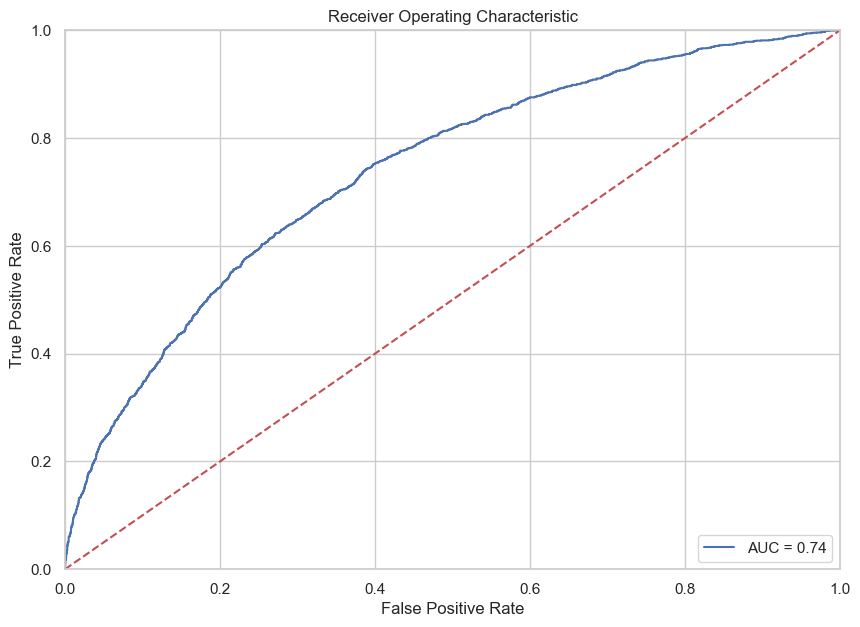

In [146]:
#Dibujamos las tasas de positivos verdaderos y falsos según el umbral que escojamos
curva_roc(y_test,y_test_pred_prob)

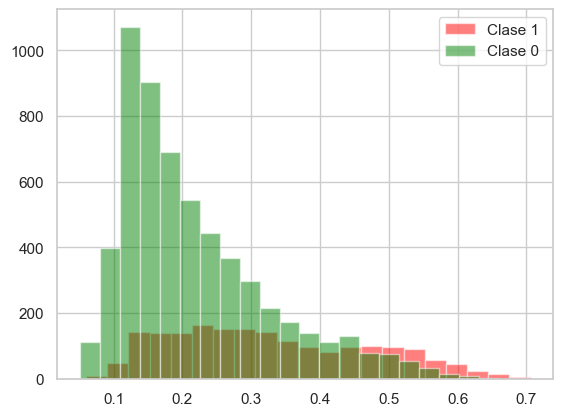

In [147]:
#Representamos las probabilidades que asigna el modelo a los datos que son 0s y en rojo las probabilidades asignadas a los datos que son 1s.
#Comprobamos que efectivamente en este cluster existe muy poca correlación
represento_doble_hist(y_test_pred_prob_pos, y_test_pred_prob_neg, n_bins=21, density=0)

In [148]:
#Mostramos las métricas según los diferentes umbrales
for umbral in np.arange(0.2,0.5,0.05):
    metricas(umbral, y_test, y_test_pred_prob)

Umbral: 0.2

Matriz de confusión
 [[3271 2605]
 [ 419 1493]]

Accuracy	0.61
Precision	0.36
Recall		0.78

F1-score	0.5


Umbral: 0.25

Matriz de confusión
 [[4103 1773]
 [ 670 1242]]

Accuracy	0.69
Precision	0.41
Recall		0.65

F1-score	0.5


Umbral: 0.3

Matriz de confusión
 [[4713 1163]
 [ 915  997]]

Accuracy	0.73
Precision	0.46
Recall		0.52

F1-score	0.49


Umbral: 0.35

Matriz de confusión
 [[5115  761]
 [1132  780]]

Accuracy	0.76
Precision	0.51
Recall		0.41

F1-score	0.45


Umbral: 0.4

Matriz de confusión
 [[5364  512]
 [1300  612]]

Accuracy	0.77
Precision	0.54
Recall		0.32

F1-score	0.4


Umbral: 0.45

Matriz de confusión
 [[5567  309]
 [1441  471]]

Accuracy	0.78
Precision	0.6
Recall		0.25

F1-score	0.35




In [149]:
#Guardamos el modelo ya entrenado en un archivo
joblib.dump(red_neuronal, 'Outputs/red_neuronal.pkl')

['Outputs/red_neuronal.pkl']

## Random Forest

In [150]:
#Leemos el csv para recuperarlo
X = pd.read_csv('Outputs/X.csv')
X

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
0,6,2,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
1,6,3,0,0,767.40000,35.70,0.00,89.22,2,326,...,0,0,0,0,0,0,0,0,0,1
2,4,2,0,0,416.16000,0.00,0.00,0.00,1,313,...,0,0,0,0,0,0,0,1,0,0
3,6,3,0,0,455.52000,24.00,59.94,59.94,4,233,...,0,0,0,0,0,0,0,1,0,0
4,2,3,0,0,173.37000,9.12,22.80,22.80,1,221,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,3,2,0,0,344.43999,18.51,46.29,46.29,1,271,...,0,0,0,0,0,0,0,1,0,0
51912,3,2,1,0,563.83500,30.06,75.18,75.18,1,243,...,0,0,0,0,0,0,0,1,0,0
51913,3,2,1,0,322.26000,17.37,43.41,43.41,1,227,...,0,0,0,0,0,0,0,1,0,0
51914,7,2,0,0,1275.31999,60.13,0.00,150.29,2,295,...,0,0,0,0,0,0,0,0,1,0


In [151]:
#Leemos el csv para recuperarlo
y = pd.read_csv('Outputs/y.csv')
y

,Estado reserva
0,0
1,0
2,1
3,0
4,0
...,...
51911,1
51912,1
51913,1
51914,1


In [152]:
#Inicializamos el escalador robusto
robust_scaler = RobustScaler()

In [153]:
#Aplicamos el escalador
X[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X[["Precio alojamiento", "Antelacion"]])

In [154]:
#Inicializamos el escalador Min-Max
scaler = MinMaxScaler()

In [155]:
#Aplicamos la normalización
X_norm = scaler.fit_transform(X)

In [156]:
#Dividimos el conjunto normalizado de datos en entrenamiento, prueba y validación
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [157]:
#Definimos el random forest
random_forest=RandomForestClassifier(n_estimators=100,
                              criterion='gini',
                              max_features='sqrt',
                              bootstrap=True,
                              max_samples=2/3,
                              oob_score=True)

In [158]:
#Ajustamos el modelo a nuestros datos de entrenamiento
random_forest.fit(X_train,y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6666666666666666,
                       oob_score=True)

In [159]:
#Obtenemos las predicciones de y_test a partir de x_test
y_test_pred_prob = random_forest.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

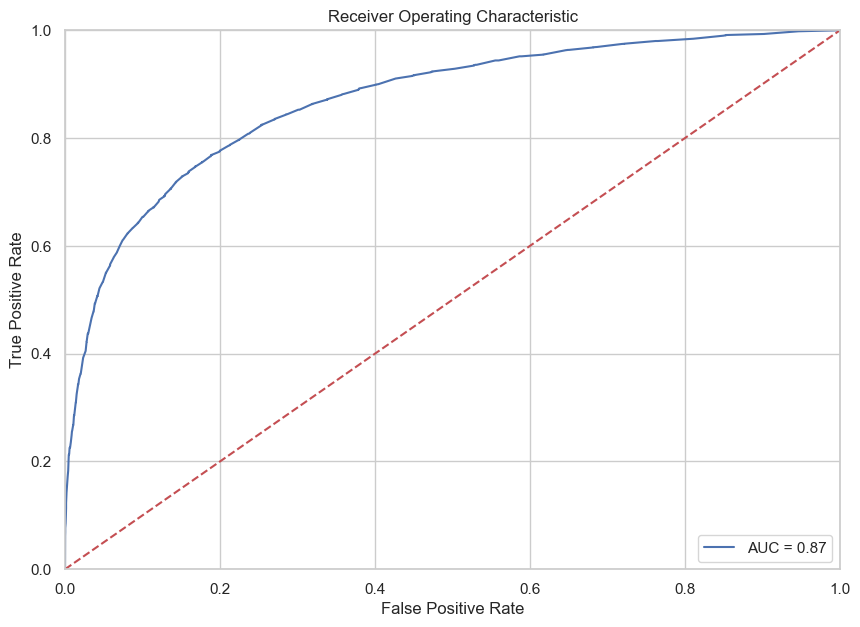

In [160]:
#Dibujamos las tasas de positivos verdaderos y falsos según el umbral que escojamos
curva_roc(y_test,y_test_pred_prob[:,1])

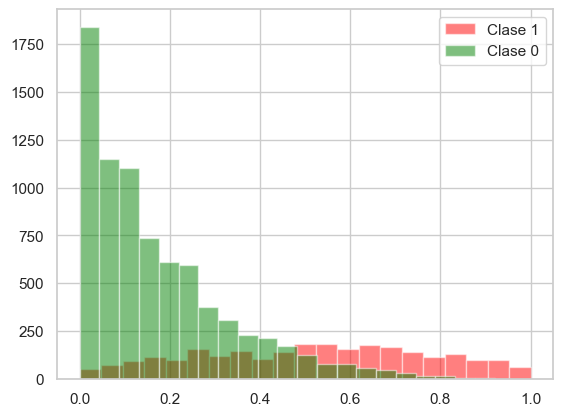

In [161]:
#Representamos las probabilidades que asigna el modelo a los datos que son 0s y en rojo las probabilidades asignadas a los datos que son 1s.
#Comprobamos que efectivamente en este cluster existe muy poca correlación
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

In [162]:
#Mostramos las métricas según los diferentes umbrales
for umbral in np.arange(0.2, 0.45, 0.05):
    metricas(umbral, y_test, y_test_pred_prob[:, 1])

Umbral: 0.2

Matriz de confusión
 [[5289 2490]
 [ 355 2250]]

Accuracy	0.73
Precision	0.47
Recall		0.86

F1-score	0.61


Umbral: 0.25

Matriz de confusión
 [[5921 1858]
 [ 495 2110]]

Accuracy	0.77
Precision	0.53
Recall		0.81

F1-score	0.64


Umbral: 0.3

Matriz de confusión
 [[6392 1387]
 [ 635 1970]]

Accuracy	0.81
Precision	0.59
Recall		0.76

F1-score	0.66


Umbral: 0.35

Matriz de confusión
 [[6713 1066]
 [ 763 1842]]

Accuracy	0.82
Precision	0.63
Recall		0.71

F1-score	0.67


Umbral: 0.4

Matriz de confusión
 [[6948  831]
 [ 877 1728]]

Accuracy	0.84
Precision	0.68
Recall		0.66

F1-score	0.67




In [163]:
#Guardamos el modelo ya entrenado en un archivo
joblib.dump(random_forest, 'Outputs/random_forest.pkl')

['Outputs/random_forest.pkl']

## Predicción de la probabilidad de cancelación

In [164]:
#Recuperamos el modelo del random forest
random_forest = joblib.load("Outputs/random_forest.pkl")

In [165]:
#Leemos el csv reservas_total_preprocesado para recuperar el dataframe
reservas_total = pd.read_csv('Outputs/reservas_total_preprocesado.csv')

#Convertimos las columnas en formato de fecha
reservas_total['Fecha entrada'] = pd.to_datetime(reservas_total['Fecha entrada'], dayfirst=True)
reservas_total['Fecha venta'] = pd.to_datetime(reservas_total['Fecha venta'], dayfirst=True)
reservas_total['Fecha Anulacion'] = pd.to_datetime(reservas_total['Fecha Anulacion'], dayfirst=True)

reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
0,0,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC,MPC,...,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September,326
1,0,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC,MPC,...,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September,326
2,1,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November,313
3,0,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November,233
4,0,2015,10539.0,1,2016-07-08,2,EC,EC,PC,PC,...,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,1,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC,PC,...,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November,271
51912,1,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC,PC,...,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November,243
51913,1,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC,PC,...,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November,227
51914,1,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC,MPC,...,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October,295


In [166]:
#Función para predecir la probabilidad de cancelación de una reserva con un modelo determinado
def predict_prob(obj, model=random_forest):
    #Recuperamos el dataframe de reservas
    reservas_total = pd.read_csv('Outputs/reservas_total_preprocesado.csv')
    
    #Recuperamos las variables que participan en la predicción del modelo
    columnas_X = ['Noches', 'Tip.Hab.Fra.', 'Régimen factura', 'AD', 'NI', 'CU', 'Horario venta',
            'Precio alojamiento', 'Precio desayuno', 'Precio almuerzo', 'Precio cena',
            'Cantidad Habitaciones', 'Mes Entrada', 'Mes Venta', 'Antelacion']

    #Tomamos nuestra base de entrenamiento para realizar el proceso de normalización y One Hot Encoding
    _sample = reservas_total[columnas_X]

    #Copiamos el objeto para eliminar la variable fecha de entrada y poder añadirlo al resto de datos
    obj_copy=obj.copy()
    obj_copy.pop('Fecha entrada')

    #Añadimos la nueva reserva a los datos
    X_new = _sample.append(obj_copy, ignore_index = True)

    #One Hot Encoding de las variables categóricas
    X_new = pd.get_dummies(X_new, columns=["Tip.Hab.Fra.", "Régimen factura", "Horario venta", "Mes Entrada", "Mes Venta"], drop_first=True)

    #Aplicamos el escalador robusto
    robust_scaler = RobustScaler()
    X_new[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X_new[["Precio alojamiento", "Antelacion"]])

    #Aplicamos la normalización Min Max
    scaler = MinMaxScaler()
    X_new = scaler.fit_transform(X_new)

    #Predecimos la probabilidad con el modelo
    prob = model.predict_proba(X_new[-1].reshape(1, -1))[0, 1]
    print('Probabilidad de cancelación: {}'.format(float(prob), 2))

    #Predecimos la probabilidad de cancelación de la nueva reserva
    return prob

In [167]:
#Función para simular nuevas reservas aleatorias
def random_Booking():
    #Recuperamos el dataframe de reservas
    reservas_total = pd.read_csv('Outputs/reservas_total_preprocesado.csv')  
    
    #Elegimos un tipo de habitación y un régimen de nuestro dataset reservas_total al azar
    room_type=random.choice(reservas_total['Tip.Hab.Fra.'].unique())
    regimen=random.choice(reservas_total['Régimen factura'].unique())

    #Fijamos la hora actual como la hora de reserva
    hora = int(datetime.now().strftime('%H'))
    if (0 <= hora < 6):
        horario = 'Madrugada'
    elif 6 <= hora < 12:
        horario = 'Mañana'
    elif 12 <= hora < 18:
        horario = 'Tarde'
    else:
        horario = 'Noche'
    
    fecha_entrada= pd.to_datetime('1/7/2024', dayfirst=True)
    fecha_entrada= pd.to_datetime(fecha_entrada, dayfirst=True)
    noches=random.choice(reservas_total['Noches'].unique())
    #Definimos el objeto con todas las variables necesarias
    obj = {
    'Fecha entrada': fecha_entrada,
    'Noches': noches ,
    'Tip.Hab.Fra.': room_type ,
    'Régimen factura': regimen,
    'AD': random.choice(reservas_total['AD'].unique()),
    'NI': random.choice(reservas_total['NI'].unique()),
    'CU': random.choice(reservas_total['CU'].unique()),
    'Horario venta': horario,
    'Precio alojamiento': reservas_total['Precio alojamiento'].loc[reservas_total['Tip.Hab.Fra.'] == room_type].mean()/reservas_total['Noches'].loc[reservas_total['Tip.Hab.Fra.'] == room_type].mean()*noches,
    'Precio desayuno': reservas_total['Precio desayuno'].loc[reservas_total['Régimen factura'] == regimen].mean(),
    'Precio almuerzo': reservas_total['Precio almuerzo'].loc[reservas_total['Régimen factura'] == regimen].mean(),
    'Precio cena': reservas_total['Precio cena'].loc[reservas_total['Régimen factura'] == regimen].mean(),
    'Cantidad Habitaciones': int(reservas_total["Cantidad Habitaciones"].loc[reservas_total['Tip.Hab.Fra.'] == room_type].mean()),
    'Mes Entrada' : fecha_entrada.strftime('%B'),
    'Mes Venta': pd.to_datetime(datetime.now()).strftime('%B'),
    'Antelacion': (fecha_entrada-pd.to_datetime(datetime.now())).days
    }

    return obj

In [168]:
objeto=random_Booking()
objeto

{'Fecha entrada': Timestamp('2024-07-01 00:00:00'),
 'Noches': 31,
 'Tip.Hab.Fra.': 'SUITE',
 'Régimen factura': 'HD',
 'AD': 6,
 'NI': 1,
 'CU': 2,
 'Horario venta': 'Noche',
 'Precio alojamiento': 813.8845573684209,
 'Precio desayuno': 17.84864294819807,
 'Precio almuerzo': 0.07649669718391469,
 'Precio cena': 0.07434349287287055,
 'Cantidad Habitaciones': 1,
 'Mes Entrada': 'July',
 'Mes Venta': 'October',
 'Antelacion': 253}

In [169]:
predict_prob(objeto)

Probabilidad de cancelación: 0.47


0.47

In [172]:
#Función para definir la cantidad mínima de habitaciones a reservar en base a huespedes y tipo de habitación
def habitaciones(adultos, niños, tipo_habitacion):
    cont = 1

    #Si es una SUITE, la capacidad máxima es de 2 adultos y 2 niños o 3 adultos
    if tipo_habitacion == 'SUITE':
        #Si hay más de 2 niños por adulto devolvemos error (0)
        if adultos * 2 < niños:
            return 0

        #Asignamos los niños de 2 en 2 y dos adultos por habitación
        cont = niños // 2 + niños % 2
        adultos -= cont * 2

        #Asignamos habitaciones de 3 adultos
        if  adultos > 0:
            cont += adultos // 3
            adultos = adultos % 3

        #Última habitación si sobran adultos
        if adultos > 0:
            cont += 1

    #Si es una habitación DELUXE VISTA COTO, la capacidad máxima es de 2 adultos y 1 niño
    if tipo_habitacion == 'DVC':
        #Si hay más niños que adultos devolvemos error (0)
        if adultos < niños:
            return 0

        #Asignamos una habitación por niño y 2 adultos por habitación
        cont = niños
        adultos -= cont * 2

        #Asignamos habitaciones de 2 adultos
        if  adultos > 0:
            cont += adultos // 2 + adultos % 2

    #Si es una habitación DELUXE VISTA MAR, la capacidad máxima es de 2 adultos. No se permiten niños
    if tipo_habitacion == 'DVM':
        #Si hay niños por adulto devolvemos error (0)
        if niños > 0:
            return 0

        #Asignamos habitaciones de 2 adultos
        cont = adultos // 2 + adultos % 2

    #Si es una habitación INDIVIDUAL, la capacidad máxima es de 1 adulto. No se permiten niños
    if tipo_habitacion == 'IND':
        #Si hay niños por adulto devolvemos error (0)
        if niños > 0:
            return 0

        #Asignamos las habitaciones individuales
        cont = adultos

    #Si es un APARTAMENTO PREMIUM, la capacidad máxima es de 4 adultos y 3 niños
    if tipo_habitacion == 'A':
        #Si hay más de 3 niños por adulto devolvemos error (0)
        if adultos * 3 < niños:
            return 0

        #Asignamos los niños de 3 en 3 y cuatro adultos por habitación
        cont = niños // 3
        niños = niños % 3
        adultos -= cont * 4

        #Si sobran niños asignamos otra habitación con capacidad para 4 adultos más
        if niños > 0:
            cont += 1
            adultos -= 4

        #Si sobran adultos asignamos habitaciones de 4 adultos
        if adultos > 0:
            cont += adultos // 4
            adultos = adultos % 4

        #Última habitación si sobran adultos
        if adultos > 0:
            cont += 1

    #Si es un ESTUDIO estándar o una habitación DOBLE SUPERIOR, independientemente de si es vista COTO o MAR,
    #la capacidad máxima es de 3 adultos y 1 niño o 2 adultos y 2 niños
    if tipo_habitacion in ('EC', 'EM', 'DSC', 'DSM'):
        #Si hay más de 2 niños por adulto devolvemos error (0)
        if adultos * 2 < niños:
            return 0

        #Asignamos los niños de 2 en 2 y dos adultos por habitación
        cont = niños // 2
        adultos -= cont * 2

        #Asignamos habitaciones de 3 en 3
        if adultos > 0:
            cont += adultos // 3
            adultos = adultos % 3

        #Última habitación si sobran adultos
        if adultos > 0:
            cont += 1
            
        #Si no sobran adultos pero sí un niño, asignaremos una habitación extra
        elif niños % 2 == 1:
            cont += 1

    return cont

In [173]:
habitaciones(3, 5, 'DSC')

3

In [175]:
#Función para crear nuevas reservas
def new_Booking(fecha_actual=pd.to_datetime(date.today())):
    #Recuperamos el dataframe de reservas
    reservas_total = pd.read_csv('Outputs/reservas_total_preprocesado.csv')

    #Introducimos la fecha de entrada
    print('Introduzca el mes de entrada: \t')
    mes_entrada = int(input())
    while (mes_entrada < 6) or (mes_entrada > 9):
        print('Mes incorrecto. Introduzca el mes de entrada: \t')
        mes_entrada = int(input())

    print('Introduzca el día de entrada: \t')
    dia_entrada = int(input())
    if mes_entrada == 7 or mes_entrada == 8:
        while (dia_entrada < 1) or (dia_entrada > 31):
            print('Día incorrecto. Introduzca el día de entrada: \t')
            dia_entrada = int(input())
    else:
        while (dia_entrada < 1) or (dia_entrada > 30):
            print('Día incorrecto. Introduzca el día de entrada: \t')
            dia_entrada = int(input())

    fecha_entrada=pd.to_datetime('{}/{}/2024'.format(dia_entrada,mes_entrada), dayfirst=True)

    #Introducimos el resto de elecciones de la reserva
    print('Seleccione la cantidad de noches: \t')
    noches = int(input())
    while (noches <= 0):
        print('Error. Introduzca una cantidad de noches correcta: \t')
        noches = int(input())

    print('Seleccione el número de adultos: \t')
    adultos = int(input())
    while (adultos <= 0):
        print('Error. Introduzca un número de adultos positivo: \t')
        adultos = int(input())

    print('Seleccione el número de niños: \t')
    niños = int(input())
    while (niños < 0):
        print('Error. Introduzca un número de niños no negativo: \t')
        niños = int(input())

    print('Seleccione el número de cunas: \t')
    cunas = int(input())
    while (cunas < 0):
        print('Error. Introduzca un número de cunas no negativo: \t')
        cunas = int(input())

    print('''Seleccione un tipo de habitación de entre los siguientes: \n
        DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE \n''')
    room_type = input()
    while (room_type not in ['DSC', 'DSM', 'DVC', 'DVM', 'EC', 'EM','A', 'IND', 'SUITE']):
        print('''Habitación incorrecta. Seleccione un tipo de habitación de entre los siguientes: \n
            DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE \n''')
        room_type = input()

    #Calculamos el número de habitaciones con la función
    num_habitaciones = habitaciones(adultos, niños, room_type)

    while (num_habitaciones == 0):
        print('''La habitación no se adecúa a sus circunstancias. Seleccione otro tipo de habitación de entre los siguientes: \n
            DSC, DSM, DVC, EC, EM, A, SUITE \n''')
        room_type = input()
        num_habitaciones = habitaciones(adultos, niños, room_type)

    print('''Seleccione un régimen de entre los siguientes: \n
        MPA, MPC, PC, SA, HD \n''')
    regimen = input()
    while (regimen not in ['MPA', 'MPC', 'PC', 'HD', 'SA']):
        print('''Régimen incorrecto. Seleccione un régimen de entre los siguientes: \n
            MPA, MPC, PC, SA, HD \n''')
        regimen = input()

    #Fijamos la hora actual como la hora de reserva
    hora = int(datetime.now().strftime('%H'))
    if (0 <= hora < 6):
        horario = 'Madrugada'
    elif hora < 12:
        horario = 'Mañana'
    elif hora < 18:
        horario = 'Tarde'
    else:
        horario = 'Noche'

      #Seleccionamos los precios enn base a las medias de habitaciones facturadas y regimenes facturados
    precio_alojamiento = reservas_total['Precio alojamiento'].loc[reservas_total['Tip.Hab.Fra.'] == room_type].mean()/reservas_total['Noches'].loc[reservas_total['Tip.Hab.Fra.'] == room_type].mean()*noches,
    precio_desayuno = reservas_total['Precio desayuno'].loc[reservas_total['Régimen factura'] == regimen].mean()
    precio_almuerzo = reservas_total['Precio almuerzo'].loc[reservas_total['Régimen factura'] == regimen].mean()
    precio_cena = reservas_total['Precio cena'].loc[reservas_total['Régimen factura'] == regimen].mean()

    #Definimos el objeto con todas las variables necesarias
    obj = {
        'Fecha entrada': fecha_entrada,
        'Noches': noches,
        'Tip.Hab.Fra.' : room_type,
        'Régimen factura': regimen,
        'AD': adultos,
        'NI': niños,
        'CU': cunas,
        'Horario venta': horario,
        'Precio alojamiento': precio_alojamiento,
        'Precio desayuno': precio_desayuno,
        'Precio almuerzo': precio_almuerzo,
        'Precio cena': precio_cena,
        'Cantidad Habitaciones': num_habitaciones,
        'Mes Entrada' : fecha_entrada.strftime('%B'),
        'Mes Venta': fecha_actual.strftime('%B'),
        'Antelacion': (fecha_entrada-fecha_actual).days
    }

    return obj

In [178]:
y_pred_new = predict_prob(new_Booking())

Introduzca el mes de entrada: 	
8
Introduzca el día de entrada: 	
4
Seleccione la cantidad de noches: 	
12
Seleccione el número de adultos: 	
2
Seleccione el número de niños: 	
1
Seleccione el número de cunas: 	
0
Seleccione un tipo de habitación de entre los siguientes: 

        DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE 

DSC
Seleccione un régimen de entre los siguientes: 

        MPA, MPC, PC, SA, HD 

PC
Probabilidad de cancelación: 0.36666666666666664


In [179]:
y_pred_new = predict_prob(new_Booking(fecha_actual=pd.to_datetime('1/5/2024', dayfirst=True)))

Introduzca el mes de entrada: 	
8
Introduzca el día de entrada: 	
4
Seleccione la cantidad de noches: 	
12
Seleccione el número de adultos: 	
2
Seleccione el número de niños: 	
1
Seleccione el número de cunas: 	
0
Seleccione un tipo de habitación de entre los siguientes: 

        DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE 

DSC
Seleccione un régimen de entre los siguientes: 

        MPA, MPC, PC, SA, HD 

PCC
Régimen incorrecto. Seleccione un régimen de entre los siguientes: 

            MPA, MPC, PC, SA, HD 


Régimen incorrecto. Seleccione un régimen de entre los siguientes: 

            MPA, MPC, PC, SA, HD 

PC
Probabilidad de cancelación: 0.20666666666666664


## Regresión lineal

In [180]:
#Leemos el csv reservas_total_preprocesado para recuperar el dataframe
reservas_total = pd.read_csv('Outputs/reservas_total_preprocesado.csv')

#Convertimos las columnas en formato de fecha
reservas_total['Fecha entrada'] = pd.to_datetime(reservas_total['Fecha entrada'], dayfirst=True)
reservas_total['Fecha venta'] = pd.to_datetime(reservas_total['Fecha venta'], dayfirst=True)
reservas_total['Fecha Anulacion'] = pd.to_datetime(reservas_total['Fecha Anulacion'], dayfirst=True)

reservas_total

,Estado reserva,Año,Reserva,Desglose,Fecha entrada,Noches,Tip.Hab.Uso,Tip.Hab.Fra.,Régimen uso,Régimen factura,...,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Horario venta,Huespedes,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
0,0,2015,10449.0,1,2016-08-14,6,DSC,DSC,MPC,MPC,...,767.40000,35.70,0.00,89.22,Tarde,2,2,August,September,326
1,0,2015,10449.0,2,2016-08-14,6,DSC,DSC,MPC,MPC,...,767.40000,35.70,0.00,89.22,Tarde,3,2,August,September,326
2,1,2015,10520.0,1,2016-09-12,4,EM,EM,SA,SA,...,416.16000,0.00,0.00,0.00,Mañana,2,1,September,November,313
3,0,2015,10523.0,4,2016-06-26,6,DSM,EC,PC,PC,...,455.52000,24.00,59.94,59.94,Tarde,3,4,June,November,233
4,0,2015,10539.0,1,2016-07-08,2,EC,EC,PC,PC,...,173.37000,9.12,22.80,22.80,Mañana,3,1,July,November,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,1,2021,6218.0,1,2022-08-15,3,DVC,DVC,PC,PC,...,344.43999,18.51,46.29,46.29,Mañana,2,1,August,November,271
51912,1,2021,6217.0,1,2022-07-17,3,DVC,DVC,PC,PC,...,563.83500,30.06,75.18,75.18,Mañana,3,1,July,November,243
51913,1,2021,6215.0,1,2022-07-01,3,DVC,DVC,PC,PC,...,322.26000,17.37,43.41,43.41,Mañana,3,1,July,November,227
51914,1,2021,6207.0,2,2022-08-17,7,DSC,DSC,MPC,MPC,...,1275.31999,60.13,0.00,150.29,Mañana,2,2,August,October,295


In [181]:
#Definimos las variables que usaremos en el modelo
columnas_canc = ['Fecha entrada', 'Fecha Anulacion', 'Fecha venta', 'Noches', 'Tip.Hab.Fra.', 'Régimen factura', 'AD',
                 'NI', 'CU', 'Horario venta', 'Precio alojamiento', 'Precio desayuno', 'Precio almuerzo',
                 'Precio cena', 'Cantidad Habitaciones', 'Mes Entrada', 'Mes Venta', 'Antelacion']

In [182]:
#Seleccionamos las columnas definidas y las filas que hayan cancelado su reserva
cancelaciones = reservas_total[columnas_canc].loc[reservas_total['Estado reserva'] == 1]
cancelaciones

,Fecha entrada,Fecha Anulacion,Fecha venta,Noches,Tip.Hab.Fra.,Régimen factura,AD,NI,CU,Horario venta,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion
2,2016-09-12,2016-02-10,2015-11-04,4,EM,SA,2,0,0,Mañana,416.16000,0.00,0.00,0.00,1,September,November,313
6,2016-07-01,2016-06-13,2015-12-01,2,EM,HD,2,0,0,Mañana,122.25000,5.10,0.00,0.00,1,July,December,213
9,2016-07-08,2016-06-04,2015-12-17,2,EC,PC,4,0,0,Tarde,178.56000,9.40,23.50,23.50,1,July,December,204
10,2016-07-18,2016-06-11,2015-12-17,7,DSC,SA,2,0,0,Tarde,469.00000,0.00,0.00,0.00,1,July,December,214
14,2016-07-12,2016-07-04,2015-12-28,5,EC,SA,2,0,0,Mañana,291.31000,0.00,0.00,0.00,1,July,December,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,2022-08-15,2022-05-29,2021-11-17,3,DVC,PC,2,0,0,Mañana,344.43999,18.51,46.29,46.29,1,August,November,271
51912,2022-07-17,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,563.83500,30.06,75.18,75.18,1,July,November,243
51913,2022-07-01,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,322.26000,17.37,43.41,43.41,1,July,November,227
51914,2022-08-17,2022-06-28,2021-10-26,7,DSC,MPC,2,0,0,Mañana,1275.31999,60.13,0.00,150.29,2,August,October,295


In [183]:
#Calculamos la tasa de cancelación
cancelaciones['Score Canc'] =  ((cancelaciones['Fecha entrada'] - cancelaciones['Fecha Anulacion']).dt.days + 1) / ((cancelaciones['Fecha entrada'] - cancelaciones['Fecha venta']).dt.days + 1)
cancelaciones

,Fecha entrada,Fecha Anulacion,Fecha venta,Noches,Tip.Hab.Fra.,Régimen factura,AD,NI,CU,Horario venta,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion,Score Canc
2,2016-09-12,2016-02-10,2015-11-04,4,EM,SA,2,0,0,Mañana,416.16000,0.00,0.00,0.00,1,September,November,313,0.687898
6,2016-07-01,2016-06-13,2015-12-01,2,EM,HD,2,0,0,Mañana,122.25000,5.10,0.00,0.00,1,July,December,213,0.088785
9,2016-07-08,2016-06-04,2015-12-17,2,EC,PC,4,0,0,Tarde,178.56000,9.40,23.50,23.50,1,July,December,204,0.170732
10,2016-07-18,2016-06-11,2015-12-17,7,DSC,SA,2,0,0,Tarde,469.00000,0.00,0.00,0.00,1,July,December,214,0.176744
14,2016-07-12,2016-07-04,2015-12-28,5,EC,SA,2,0,0,Mañana,291.31000,0.00,0.00,0.00,1,July,December,197,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,2022-08-15,2022-05-29,2021-11-17,3,DVC,PC,2,0,0,Mañana,344.43999,18.51,46.29,46.29,1,August,November,271,0.290441
51912,2022-07-17,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,563.83500,30.06,75.18,75.18,1,July,November,243,0.569672
51913,2022-07-01,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,322.26000,17.37,43.41,43.41,1,July,November,227,0.539474
51914,2022-08-17,2022-06-28,2021-10-26,7,DSC,MPC,2,0,0,Mañana,1275.31999,60.13,0.00,150.29,2,August,October,295,0.172297


In [184]:
#Guardamos el dataframe en un nuevo archivo CSV
cancelaciones.to_csv("Outputs/cancelaciones.csv", index=False)

In [185]:
#Leemos el csv para recuperar el dataframe de cancelaciones
cancelaciones = pd.read_csv('Outputs/cancelaciones.csv')
cancelaciones

,Fecha entrada,Fecha Anulacion,Fecha venta,Noches,Tip.Hab.Fra.,Régimen factura,AD,NI,CU,Horario venta,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion,Score Canc
0,2016-09-12,2016-02-10,2015-11-04,4,EM,SA,2,0,0,Mañana,416.16000,0.00,0.00,0.00,1,September,November,313,0.687898
1,2016-07-01,2016-06-13,2015-12-01,2,EM,HD,2,0,0,Mañana,122.25000,5.10,0.00,0.00,1,July,December,213,0.088785
2,2016-07-08,2016-06-04,2015-12-17,2,EC,PC,4,0,0,Tarde,178.56000,9.40,23.50,23.50,1,July,December,204,0.170732
3,2016-07-18,2016-06-11,2015-12-17,7,DSC,SA,2,0,0,Tarde,469.00000,0.00,0.00,0.00,1,July,December,214,0.176744
4,2016-07-12,2016-07-04,2015-12-28,5,EC,SA,2,0,0,Mañana,291.31000,0.00,0.00,0.00,1,July,December,197,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13032,2022-08-15,2022-05-29,2021-11-17,3,DVC,PC,2,0,0,Mañana,344.43999,18.51,46.29,46.29,1,August,November,271,0.290441
13033,2022-07-17,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,563.83500,30.06,75.18,75.18,1,July,November,243,0.569672
13034,2022-07-01,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,322.26000,17.37,43.41,43.41,1,July,November,227,0.539474
13035,2022-08-17,2022-06-28,2021-10-26,7,DSC,MPC,2,0,0,Mañana,1275.31999,60.13,0.00,150.29,2,August,October,295,0.172297


In [186]:
#Elegimos las variables que usaremos en el modelo de cancelaciones
columnas_canc_X = ['Noches', 'Tip.Hab.Fra.', 'Régimen factura', 'AD', 'NI', 'CU', 'Horario venta', 'Precio alojamiento', 'Precio desayuno',
                   'Precio almuerzo', 'Precio cena', 'Cantidad Habitaciones', 'Mes Entrada', 'Mes Venta', 'Antelacion']

#Dividimos en X e y
X_canc = cancelaciones[columnas_canc_X]
y_canc = cancelaciones['Score Canc']
y_canc

0        0.687898
1        0.088785
2        0.170732
3        0.176744
4        0.045455
           ...   
13032    0.290441
13033    0.569672
13034    0.539474
13035    0.172297
13036    0.172297
Name: Score Canc, Length: 13037, dtype: float64

In [187]:
#Comprobamos que no hay nulos
y_canc.isnull().sum()

0

In [188]:
#One Hot Encoding de las variables categóricas
X_canc = pd.get_dummies(X_canc, columns=["Tip.Hab.Fra.", "Régimen factura","Horario venta", "Mes Entrada", "Mes Venta"], drop_first=True)
X_canc

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
0,4,2,0,0,416.16000,0.00,0.00,0.00,1,313,...,0,0,0,0,0,0,0,1,0,0
1,2,2,0,0,122.25000,5.10,0.00,0.00,1,213,...,1,0,0,0,0,0,0,0,0,0
2,2,4,0,0,178.56000,9.40,23.50,23.50,1,204,...,1,0,0,0,0,0,0,0,0,0
3,7,2,0,0,469.00000,0.00,0.00,0.00,1,214,...,1,0,0,0,0,0,0,0,0,0
4,5,2,0,0,291.31000,0.00,0.00,0.00,1,197,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13032,3,2,0,0,344.43999,18.51,46.29,46.29,1,271,...,0,0,0,0,0,0,0,1,0,0
13033,3,2,1,0,563.83500,30.06,75.18,75.18,1,243,...,0,0,0,0,0,0,0,1,0,0
13034,3,2,1,0,322.26000,17.37,43.41,43.41,1,227,...,0,0,0,0,0,0,0,1,0,0
13035,7,2,0,0,1275.31999,60.13,0.00,150.29,2,295,...,0,0,0,0,0,0,0,0,1,0


In [189]:
#Comprobamos algunas de las columnas con valores extremos
X_canc[["Precio alojamiento", "Cantidad Habitaciones", "Antelacion"]].describe()

,Precio alojamiento,Cantidad Habitaciones,Antelacion
count,13037.000000,13037.000000,13037.000000
mean,520.459741,1.319169,45.346706
std,367.370327,0.673943,46.567262
min,-10.000000,1.000000,0.000000
25%,278.300000,1.000000,15.000000
50%,428.740000,1.000000,28.000000
75%,669.840000,1.000000,57.000000
max,8208.030070,5.000000,313.000000


In [190]:
# Este escalador es resistente a los valores atípicos y se basa en la mediana y el rango intercuartílico
# en lugar de la media y la desviación estándar. Es útil cuando los datos contienen valores extremos.

# Como es el caso de las Columnas "Precio alojamiento" y "Antelacion"
robust_scaler = RobustScaler()
X_canc[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X_canc[["Precio alojamiento", "Antelacion"]])

X_canc[["Precio alojamiento", "Antelacion"]].describe()

,Precio alojamiento,Antelacion
count,13037.000000,13037.000000
mean,0.234254,0.413017
std,0.938270,1.108744
min,-1.120550,-0.666667
25%,-0.384226,-0.309524
50%,0.000000,0.000000
75%,0.615774,0.690476
max,19.868443,6.785714


In [191]:
#Inicializamos el escalador Min-Max
scaler = MinMaxScaler()

In [192]:
#Aplicamos la normalización
X_norm_canc = scaler.fit_transform(X_canc)

In [193]:
#Dividimos el conjunto normalizado de datos en entrenamiento, prueba y validación
X_train, X_test, y_train, y_test = train_test_split(X_norm_canc, y_canc, test_size=0.2, random_state=42)

In [194]:
#Definimos el modelo de regresión lineal
modelo = Ridge()
parametros = {"alpha": list(range(1,20, 1))}

In [195]:
#Buscamos ajustar nuestro modelo con los mejores parámetros
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='neg_mean_squared_error')
modelo_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19]},
             scoring='neg_mean_squared_error')

In [196]:
#Imprimimos el mejor parámetro y su error cuadrático medio
print(modelo_gs.best_params_, ("\nrmse: %f" % np.sqrt(-modelo_gs.best_score_)) )

{'alpha': 1} 
rmse: 0.306305


In [197]:
#Ajustamos los parámetros para nuestro modelo
reg_lineal =  Ridge(alpha=modelo_gs.best_params_['alpha'])

In [198]:
#Ajustamos nuestro conjunto de entrenamiento al modelo de regresión lineal
reg_lineal.fit(X_train, y_train)

Ridge(alpha=1)

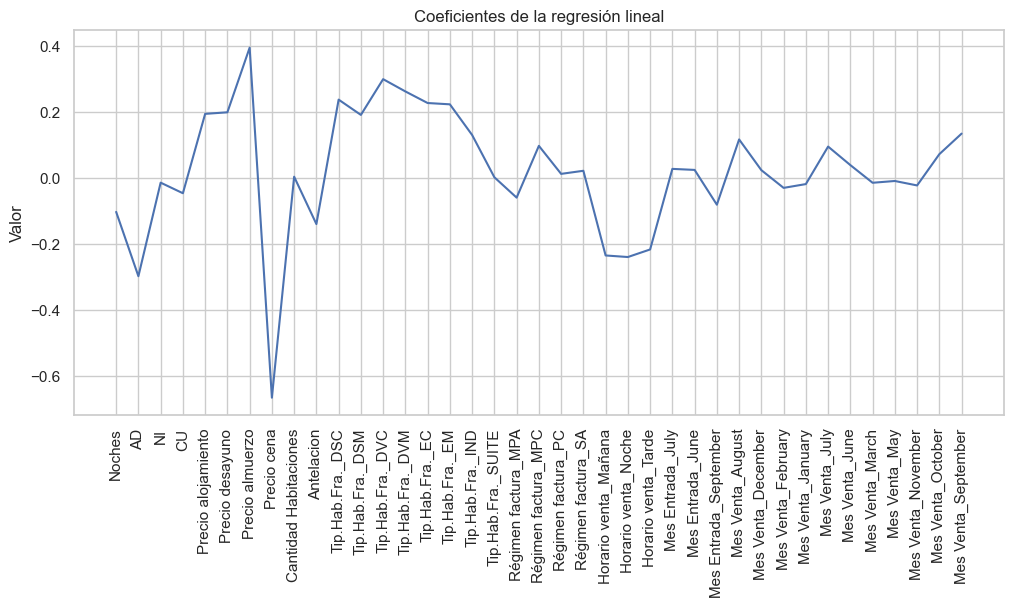

In [199]:
#Dibujamos los coeficientes para cada variable
n_ticks = len(reg_lineal.coef_)
plt.figure(figsize=(12,5))
plt.title(u'Coeficientes de la regresión lineal')
plt.ylabel('Valor')
plt.xticks(range(n_ticks), X_canc.columns, rotation='vertical')
_ = plt.plot(reg_lineal.coef_)

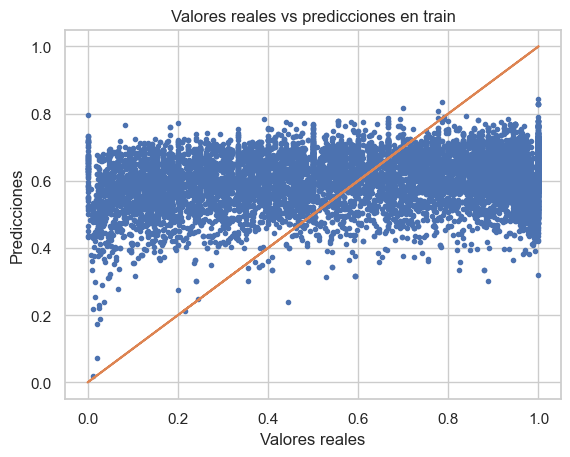

In [200]:
#Dibujamos la comparativa de valores reales con predicciones en el train
y_train_pred = reg_lineal.predict(X_train)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(y_train, y_train_pred, '.', y_train, y_train, '-')

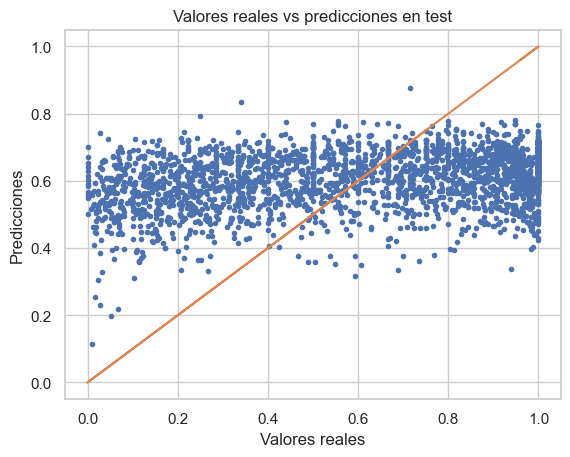

In [201]:
#Dibujamos la comparativa de valores reales con predicciones en el test
y_test_pred = reg_lineal.predict(X_test)
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(y_test, y_test_pred, '.', y_test, y_test, '-')

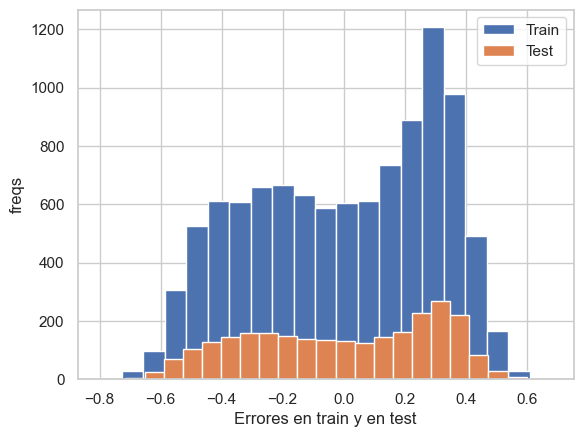

In [202]:
#Dibujamos el error en train y test
plt.xlabel('Errores en train y en test')
plt.ylabel('freqs')
plt.hist(y_train - y_train_pred, bins=21, label='Train')
plt.hist(y_test - y_test_pred, bins=21, label='Test')
_ = plt.legend()

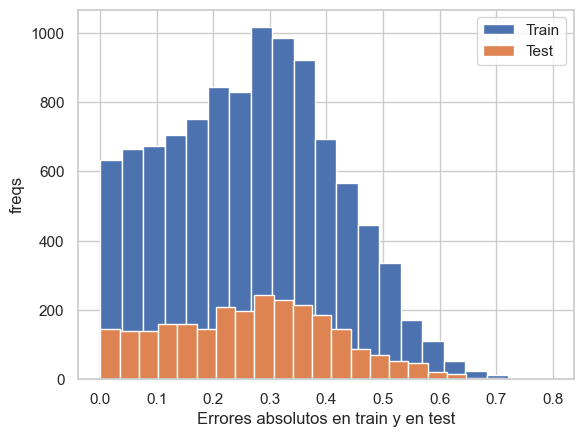

In [203]:
#Dibujamos el error absoluto en train y test
plt.xlabel('Errores absolutos en train y en test')
plt.ylabel('freqs')
plt.hist(abs(y_train - y_train_pred), bins=21, label='Train')
plt.hist(abs(y_test - y_test_pred), bins=21, label='Test')
_ = plt.legend()

In [204]:
#Calculamos el error cuadrático medio en train y test
error_mse_train = round(mean_squared_error(y_train, y_train_pred),2)
error_mse_test = round(mean_squared_error(y_test, y_test_pred),2)
print('El error cuadrático medio en train es: {}'.format(error_mse_train))
print('El error cuadrático medio en test es: {}'.format(error_mse_test))

El error cuadrático medio en train es: 0.09
El error cuadrático medio en test es: 0.09


In [205]:
#Guardamos el modelo ya entrenado en un archivo para poderlo usar luego ya entrenado
joblib.dump(reg_lineal, 'Outputs/linear_regression.pkl')

['Outputs/linear_regression.pkl']

## Regresión con Random forest

In [206]:
#Leemos el csv para recuperar el dataframe de cancelaciones
cancelaciones = pd.read_csv('Outputs/cancelaciones.csv')
cancelaciones

,Fecha entrada,Fecha Anulacion,Fecha venta,Noches,Tip.Hab.Fra.,Régimen factura,AD,NI,CU,Horario venta,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion,Score Canc
0,2016-09-12,2016-02-10,2015-11-04,4,EM,SA,2,0,0,Mañana,416.16000,0.00,0.00,0.00,1,September,November,313,0.687898
1,2016-07-01,2016-06-13,2015-12-01,2,EM,HD,2,0,0,Mañana,122.25000,5.10,0.00,0.00,1,July,December,213,0.088785
2,2016-07-08,2016-06-04,2015-12-17,2,EC,PC,4,0,0,Tarde,178.56000,9.40,23.50,23.50,1,July,December,204,0.170732
3,2016-07-18,2016-06-11,2015-12-17,7,DSC,SA,2,0,0,Tarde,469.00000,0.00,0.00,0.00,1,July,December,214,0.176744
4,2016-07-12,2016-07-04,2015-12-28,5,EC,SA,2,0,0,Mañana,291.31000,0.00,0.00,0.00,1,July,December,197,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13032,2022-08-15,2022-05-29,2021-11-17,3,DVC,PC,2,0,0,Mañana,344.43999,18.51,46.29,46.29,1,August,November,271,0.290441
13033,2022-07-17,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,563.83500,30.06,75.18,75.18,1,July,November,243,0.569672
13034,2022-07-01,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,322.26000,17.37,43.41,43.41,1,July,November,227,0.539474
13035,2022-08-17,2022-06-28,2021-10-26,7,DSC,MPC,2,0,0,Mañana,1275.31999,60.13,0.00,150.29,2,August,October,295,0.172297


In [207]:
#Definimos las variables que usaremos en el modelo
columnas_canc_X = ['Noches', 'Tip.Hab.Fra.', 'Régimen factura', 'AD', 'NI', 'CU', 'Horario venta', 'Precio alojamiento', 'Precio desayuno',
                   'Precio almuerzo', 'Precio cena', 'Cantidad Habitaciones', 'Mes Entrada', 'Mes Venta', 'Antelacion']

#Dividimos en X e y
X_canc = cancelaciones[columnas_canc_X]
y_canc = cancelaciones['Score Canc']
y_canc

0        0.687898
1        0.088785
2        0.170732
3        0.176744
4        0.045455
           ...   
13032    0.290441
13033    0.569672
13034    0.539474
13035    0.172297
13036    0.172297
Name: Score Canc, Length: 13037, dtype: float64

In [208]:
#One Hot Encoding de las variables categóricas
X_canc = pd.get_dummies(X_canc, columns=["Tip.Hab.Fra.", "Régimen factura","Horario venta", "Mes Entrada", "Mes Venta"], drop_first=True)
X_canc

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
0,4,2,0,0,416.16000,0.00,0.00,0.00,1,313,...,0,0,0,0,0,0,0,1,0,0
1,2,2,0,0,122.25000,5.10,0.00,0.00,1,213,...,1,0,0,0,0,0,0,0,0,0
2,2,4,0,0,178.56000,9.40,23.50,23.50,1,204,...,1,0,0,0,0,0,0,0,0,0
3,7,2,0,0,469.00000,0.00,0.00,0.00,1,214,...,1,0,0,0,0,0,0,0,0,0
4,5,2,0,0,291.31000,0.00,0.00,0.00,1,197,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13032,3,2,0,0,344.43999,18.51,46.29,46.29,1,271,...,0,0,0,0,0,0,0,1,0,0
13033,3,2,1,0,563.83500,30.06,75.18,75.18,1,243,...,0,0,0,0,0,0,0,1,0,0
13034,3,2,1,0,322.26000,17.37,43.41,43.41,1,227,...,0,0,0,0,0,0,0,1,0,0
13035,7,2,0,0,1275.31999,60.13,0.00,150.29,2,295,...,0,0,0,0,0,0,0,0,1,0


In [209]:
#Comprobamos algunas de las columnas con valores extremos
X_canc.describe()

,Noches,AD,NI,CU,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Antelacion,...,Mes Venta_December,Mes Venta_February,Mes Venta_January,Mes Venta_July,Mes Venta_June,Mes Venta_March,Mes Venta_May,Mes Venta_November,Mes Venta_October,Mes Venta_September
count,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,...,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000,13037.000000
mean,3.908951,2.190151,0.223057,0.062514,520.459741,21.207248,34.261605,33.096031,1.319169,45.346706,...,0.003222,0.036051,0.022398,0.340416,0.207486,0.039196,0.115978,0.003989,0.001227,0.013347
std,2.350940,0.518129,0.540572,0.250199,367.370327,19.698249,49.803789,48.184106,0.673943,46.567262,...,0.056670,0.186425,0.147979,0.473867,0.405522,0.194069,0.320210,0.063032,0.035012,0.114758
min,1.000000,1.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,278.300000,7.920000,0.000000,0.000000,1.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,428.740000,18.100000,0.000000,0.000000,1.000000,28.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,0.000000,669.840000,29.950000,57.180000,56.070000,1.000000,57.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61.000000,6.000000,3.000000,2.000000,8208.030070,439.810000,1099.830000,1099.830000,5.000000,313.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [210]:
# Este escalador es resistente a los valores atípicos y se basa en la mediana y el rango intercuartílico
# en lugar de la media y la desviación estándar. Es útil cuando los datos contienen valores extremos.

# Como es el caso de las Columnas "Precio alojamiento" y "Antelacion"
robust_scaler = RobustScaler()
X_canc[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X_canc[["Precio alojamiento", "Antelacion"]])

X_canc[["Precio alojamiento", "Antelacion"]].describe()

,Precio alojamiento,Antelacion
count,13037.000000,13037.000000
mean,0.234254,0.413017
std,0.938270,1.108744
min,-1.120550,-0.666667
25%,-0.384226,-0.309524
50%,0.000000,0.000000
75%,0.615774,0.690476
max,19.868443,6.785714


In [211]:
# Inicializamos el escalador Min-Max
scaler = MinMaxScaler()

In [212]:
# Aplicamos la normalización
X_norm_canc = scaler.fit_transform(X_canc)

In [213]:
# Dividimos el conjunto normalizado de datos en entrenamiento, prueba y validación
X_train, X_test, y_train, y_test = train_test_split(X_norm_canc, y_canc, test_size=0.2, random_state=42)

In [214]:
#Definimos el modelo de regresión con random forest
modelo = RandomForestRegressor()
parametros = {"n_estimators": [10,20,50], "max_depth":range(1,20)}

In [215]:
#Buscamos ajustar nuestro modelo con los mejores parámetros
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='neg_mean_squared_error')
modelo_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 20),
                         'n_estimators': [10, 20, 50]},
             scoring='neg_mean_squared_error')

In [216]:
#Imprimimos el mejor parámetro y su error cuadrático medio
print(modelo_gs.best_params_, ("\nrmse: %f" % np.sqrt(-modelo_gs.best_score_)))

{'max_depth': 19, 'n_estimators': 50} 
rmse: 0.276013


In [217]:
#Ajustamos los parámetros para nuestro modelo
reg_random_forest =  RandomForestRegressor(max_depth=modelo_gs.best_params_['max_depth'],
                                      n_estimators=modelo_gs.best_params_['n_estimators'])

In [218]:
#Ajustamos nuestro conjunto de entrenamiento al modelo de regresión lineal
reg_random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=19, n_estimators=50)

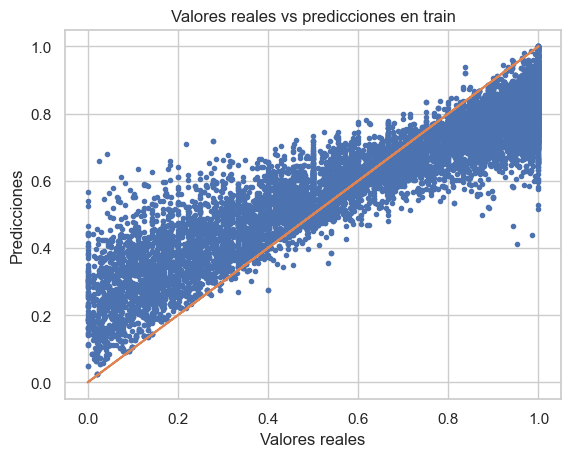

In [219]:
#Dibujamos la comparativa de valores reales con predicciones en el train
y_train_pred = reg_random_forest.predict(X_train)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(y_train, y_train_pred, '.', y_train, y_train, '-')

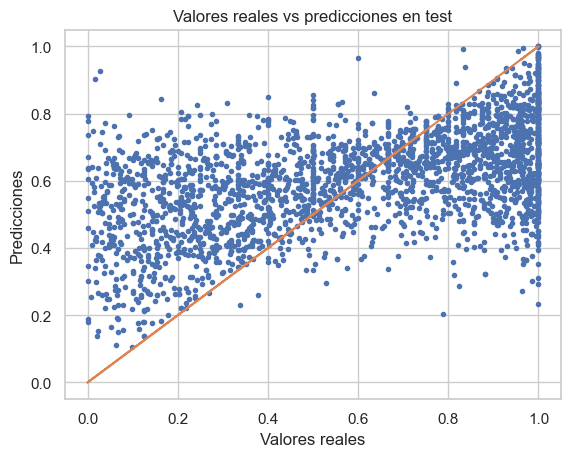

In [220]:
#Dibujamos la comparativa de valores reales con predicciones en el test
y_test_pred = reg_random_forest.predict(X_test)
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(y_test, y_test_pred, '.', y_test, y_test, '-')

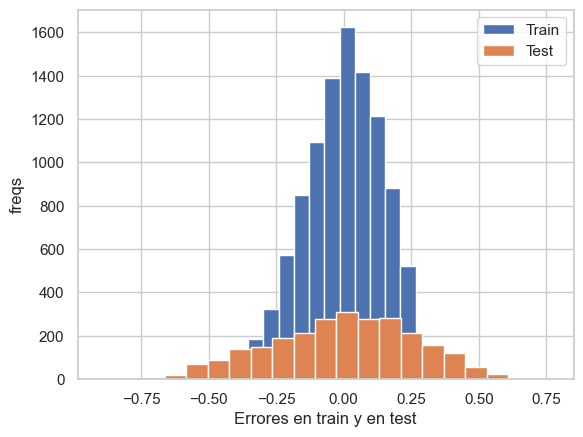

In [221]:
#Dibujamos el error en train y test
plt.xlabel('Errores en train y en test')
plt.ylabel('freqs')
plt.hist(y_train - y_train_pred, bins=21, label='Train')
plt.hist(y_test - y_test_pred, bins=21, label='Test')
_ = plt.legend()

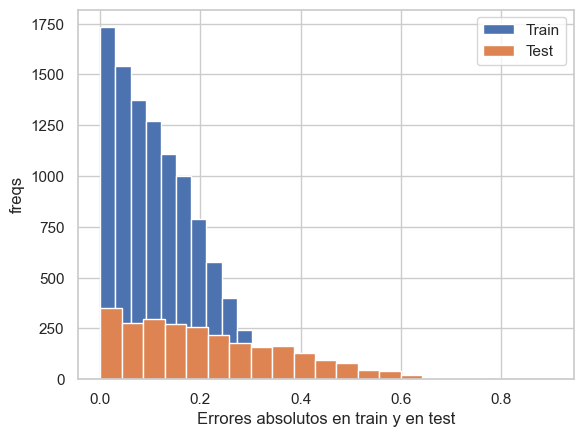

In [222]:
#Dibujamos el error absoluto en train y test
plt.xlabel('Errores absolutos en train y en test')
plt.ylabel('freqs')
plt.hist(abs(y_train - y_train_pred), bins=21, label='Train')
plt.hist(abs(y_test - y_test_pred), bins=21, label='Test')
_ = plt.legend()

In [223]:
#Calculamos el error cuadrático medio en train y test
error_mse_train = round(mean_squared_error(y_train, y_train_pred),2)
error_mse_test = round(mean_squared_error(y_test, y_test_pred),2)
print('El error cuadrático medio en train es: {}'.format(error_mse_train))
print('El error cuadrático medio en test es: {}'.format(error_mse_test))

El error cuadrático medio en train es: 0.02
El error cuadrático medio en test es: 0.07


0.5094229078821761

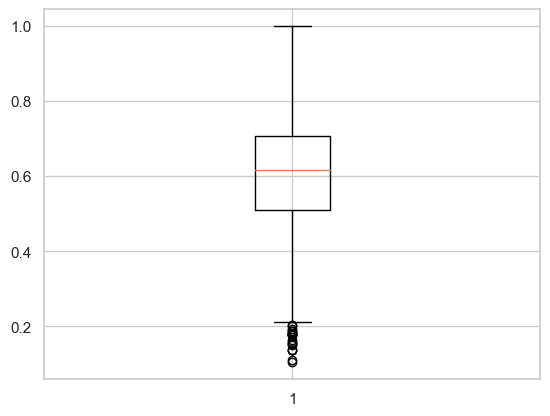

In [224]:
#Observamos el boxplot de las predicciones. Usaremos el umbral de 0.5
plt.boxplot(y_test_pred)

np.percentile(y_test_pred,25)

In [225]:
#Guardamos el modelo ya entrenado en un archivo para poderlo usar luego ya entrenado
joblib.dump(reg_random_forest, 'Outputs/reg_random_forest.pkl')

['Outputs/reg_random_forest.pkl']

## Predicción de la fecha de cancelación

In [228]:
#Recuperamos el modelo del regresor con random forest
random_forest_canc = joblib.load("Outputs/reg_random_forest.pkl")

In [229]:
#Leemos el csv para recuperar el dataframe de cancelaciones
cancelaciones = pd.read_csv('Outputs/cancelaciones.csv')

cancelaciones

,Fecha entrada,Fecha Anulacion,Fecha venta,Noches,Tip.Hab.Fra.,Régimen factura,AD,NI,CU,Horario venta,Precio alojamiento,Precio desayuno,Precio almuerzo,Precio cena,Cantidad Habitaciones,Mes Entrada,Mes Venta,Antelacion,Score Canc
0,2016-09-12,2016-02-10,2015-11-04,4,EM,SA,2,0,0,Mañana,416.16000,0.00,0.00,0.00,1,September,November,313,0.687898
1,2016-07-01,2016-06-13,2015-12-01,2,EM,HD,2,0,0,Mañana,122.25000,5.10,0.00,0.00,1,July,December,213,0.088785
2,2016-07-08,2016-06-04,2015-12-17,2,EC,PC,4,0,0,Tarde,178.56000,9.40,23.50,23.50,1,July,December,204,0.170732
3,2016-07-18,2016-06-11,2015-12-17,7,DSC,SA,2,0,0,Tarde,469.00000,0.00,0.00,0.00,1,July,December,214,0.176744
4,2016-07-12,2016-07-04,2015-12-28,5,EC,SA,2,0,0,Mañana,291.31000,0.00,0.00,0.00,1,July,December,197,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13032,2022-08-15,2022-05-29,2021-11-17,3,DVC,PC,2,0,0,Mañana,344.43999,18.51,46.29,46.29,1,August,November,271,0.290441
13033,2022-07-17,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,563.83500,30.06,75.18,75.18,1,July,November,243,0.569672
13034,2022-07-01,2022-03-01,2021-11-16,3,DVC,PC,2,1,0,Mañana,322.26000,17.37,43.41,43.41,1,July,November,227,0.539474
13035,2022-08-17,2022-06-28,2021-10-26,7,DSC,MPC,2,0,0,Mañana,1275.31999,60.13,0.00,150.29,2,August,October,295,0.172297


In [230]:
#Función para predecir la fecha de cancelación de la reserva
def predict_date_score(obj: dict,model_canc=random_forest_canc, fecha_actual=date.today()):
    #Recuperamos el dataframe de reservas
    reservas_total = pd.read_csv('Outputs/cancelaciones.csv')
  
    #Definimos las variables que usaremos en el modelo
    columnas_canc_X = ['Noches', 'Tip.Hab.Fra.', 'Régimen factura', 'AD', 'NI', 'CU', 'Horario venta', 'Precio alojamiento', 'Precio desayuno',
                   'Precio almuerzo', 'Precio cena', 'Cantidad Habitaciones', 'Mes Entrada', 'Mes Venta', 'Antelacion']
    #Tomamos nuestra base de entrenamiento para realizar el proceso de normalización y One Hot Encoding
    _sample = cancelaciones[columnas_canc_X]

    #Copiamos el objeto para eliminar la variable fecha de entrada y poder añadirlo al resto de datos
    obj_copy=obj.copy()
    obj_copy.pop('Fecha entrada')

    #Añadimos la nueva reserva a los datos
    X_new = _sample.append(obj_copy,ignore_index=True)

    #One Hot Encoding de las variables categóricas
    X_new = pd.get_dummies(X_new, columns=["Tip.Hab.Fra.", "Régimen factura","Horario venta", "Mes Entrada", "Mes Venta"], drop_first=True)

    #Aplicamos el escalador robusto
    robust_scaler = RobustScaler()
    X_new[["Precio alojamiento", "Antelacion"]] = robust_scaler.fit_transform(X_new[["Precio alojamiento", "Antelacion"]])

    # Aplicamos la normalización Min Max
    X_norm = MinMaxScaler().fit_transform(X_new)

    #Predecimos el score con el modelo
    _score = model_canc.predict(X_norm[-1].reshape(1, -1))[0]

    #Si el score es menor que el primer cuartil, consideramos que la cancelación podría ser tardía
    if _score < 0.5:
        print(f"¡¡Aviso de posible cancelación tardía!!")
    return _score

In [231]:
predict_date_score(random_Booking())

¡¡Aviso de posible cancelación tardía!!


0.4792313002616491

In [232]:
predict_date_score(new_Booking())

Introduzca el mes de entrada: 	
8
Introduzca el día de entrada: 	
4
Seleccione la cantidad de noches: 	
12
Seleccione el número de adultos: 	
2
Seleccione el número de niños: 	
1
Seleccione el número de cunas: 	
0
Seleccione un tipo de habitación de entre los siguientes: 

        DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE 

DS
Habitación incorrecta. Seleccione un tipo de habitación de entre los siguientes: 

            DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE 

DSC
Seleccione un régimen de entre los siguientes: 

        MPA, MPC, PC, SA, HD 

PC
¡¡Aviso de posible cancelación tardía!!


0.46161346238433915

In [233]:
#Función cuota no reembolsable
def func_no_reembolso(_obj, _cuota_media=0.10, _cuota_maxima=0.25, _umbral_inferior=0.25, _umbral_superior=0.4, model=random_forest, model_canc=random_forest_canc):
    #Condiciones de control
    if 0 <= _cuota_maxima <= 1:
        if 0 <= _cuota_media <= 1:
            if 0 <= _umbral_inferior <= 1:
                if 0 <= _umbral_superior <= 1:
                    if _umbral_superior >_umbral_inferior:

                        #Predicción de la probabilidad de cancelación
                        _pred = predict_prob(_obj, model)

                        #Según los distintos umbrales y dependiendo del score, las cancelaciones tendrán unas cuotas y fechas de cancelación
                        if _pred < _umbral_inferior:
                            if predict_date_score(_obj,model_canc)<0.5:
                                print(f"Riesgo bajo de cancelación.\nEl huésped podrá cancelar sin costo hasta 7 días antes del {_obj['Fecha entrada']}")
                            else:
                                print(f"Riesgo bajo de cancelación.\nEl huésped podrá cancelar sin costo hasta 24 horas antes del {_obj['Fecha entrada']}")
                        elif _pred > _umbral_superior:
                            if predict_date_score(_obj,model_canc)<0.5:
                                print(f"Riesgo alto de cancelación.\nEl huésped podrá cancelar perdiendo un {(_cuota_maxima)*100:.1f}% del Precio total hasta 30 días antes del {_obj['Fecha entrada']}")
                            else:
                                print(f"Riesgo alto de cancelación.\nEl huésped podrá cancelar perdiendo un {(_cuota_maxima)*100:.1f}% del Precio total hasta 7 días antes del {_obj['Fecha entrada']}")
                        else:
                            if predict_date_score(_obj,model_canc)<0.5:
                                print(f"Riesgo moderado de cancelación.\nEl huésped podrá cancelar perdiendo un {(_cuota_media)*100:.1f}% del Precio total hasta 14 días antes del {_obj['Fecha entrada']}")
                            else:
                                print(f"Riesgo moderado de cancelación.\nEl huésped podrá cancelar perdiendo un {(_cuota_media)*100:.1f}% del Precio total hasta 48 horas antes del {_obj['Fecha entrada']}")
                    else:
                        raise ValueError("El valor de ´umbral_superior´  tiene que ser mayor que ´umbral_inferior´.")
                else:
                    raise ValueError("El valor ´umbral_superior´ debe estar entre 0 y 1.")
            else:
                raise ValueError("El valor ´umbral_inferior´ debe estar entre 0 y 1.")
        else:
            raise ValueError("El valor ´cuota_media´ debe estar entre 0 y 1.")
    else:
        raise ValueError("El valor ´cuota_maxima´ debe estar entre 0 y 1.")

In [234]:
func_no_reembolso(random_Booking())

Probabilidad de cancelación: 0.52
¡¡Aviso de posible cancelación tardía!!
Riesgo alto de cancelación.
El huésped podrá cancelar perdiendo un 25.0% del Precio total hasta 30 días antes del 2024-07-01 00:00:00


In [235]:
func_no_reembolso(new_Booking())

Introduzca el mes de entrada: 	
8
Introduzca el día de entrada: 	
4
Seleccione la cantidad de noches: 	
12
Seleccione el número de adultos: 	
2
Seleccione el número de niños: 	
1
Seleccione el número de cunas: 	
0
Seleccione un tipo de habitación de entre los siguientes: 

        DSC, DSM, DVC, DVM, EC, EM, A, IND, SUITE 

DSC
Seleccione un régimen de entre los siguientes: 

        MPA, MPC, PC, SA, HD 

PC
Probabilidad de cancelación: 0.36666666666666664
¡¡Aviso de posible cancelación tardía!!
Riesgo moderado de cancelación.
El huésped podrá cancelar perdiendo un 10.0% del Precio total hasta 14 días antes del 2024-08-04 00:00:00
